# Environment setup

In [2]:
from scipy.io import loadmat
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
np.random.seed(260)
import itertools

# Path to musicImagery dataset
dataDir = r'../../data/musicImagery/'
#dataDir = r'D:\marion_music_imagery\datasetCND_musicImagery\musicImagery'

# Load stimuli
Note: ```stimIndxs``` range from 1 to 4 and ```condIdxs``` range from 1-2.
These are _not_ 0-indexed.

In [3]:
stim_mat = loadmat(dataDir+r"/dataCND/dataStim.mat", simplify_cells = True) 
stim = stim_mat['stim']
# print(stim)

stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape (N trials): {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape (N trials): {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape (P conditions): {condNames.shape}')

stim_events = stim['data']
print(f'events shape (M features, N trials): {stim_events.shape}')

stim_event_labels = stim['names']
print(f'event names shape (M features): {stim_event_labels.shape}')

fs_stim = stim['fs'] # ignore, use fs from data struct (64 Hz)
print(f'fs: {fs_stim} Hz')

stimIdxs shape (N trials): (88,)
condIdxs shape (N trials): (88,)
condNames shape (P conditions): (2,)
events shape (M features, N trials): (2, 88)
event names shape (M features): (2,)
fs: 64 Hz


In [4]:
# Handy mapping of indices to labels
stimId_to_Song_map = {
    2: 'chor-038', 
    1: 'chor-096', 
    3: 'chor-101',
    4: 'chor-019', 
} # from read_stim_midi.ipynb

stimLabel_to_id_map = {
    'chor-038': 2, 
    'chor-096': 1, 
    'chor-101': 3,
    'chor-019': 4, 
} # reverse mapping

stimLabel_to_sheet_order_map = {
    'chor-038': 1, 
    'chor-096': 2, 
    'chor-101': 3,
    'chor-019': 4, 
} # order of songs on sheet music

condId_to_State_map = {
    1: 'Listening', 
    2: 'Imagery'
} # from condNames

# Stim Channel

Finding tactile metronome onsets

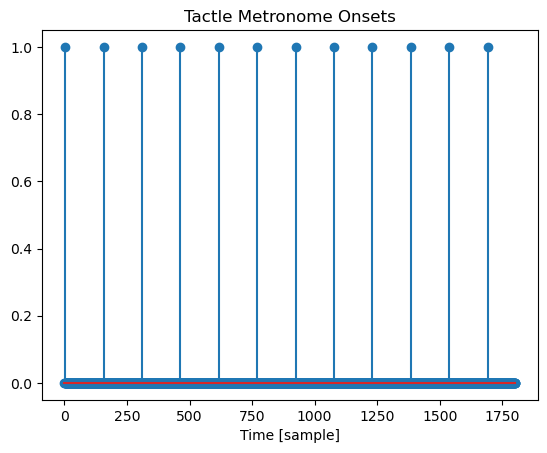

In [5]:
# From Guilhem's note
barOnsets = [1, 157] # in sample indices

cueTime = 310 # third bar
for barIdx in range(10): # 12 bars total
    barOnsets.append(cueTime)
    if barIdx%2 == 1:
        cueTime += 153
    else:
        cueTime += 154
        
cueTime -= 1 # index from 0

# Make a new exp vector for metronome hits
cueExp = np.zeros_like(stim_events[1][0]) # same size as the first expectation vector
cueExp[barOnsets] = 1

plt.figure()
plt.stem(cueExp, '*')
plt.xlabel('Time [sample]')
plt.title('Tactle Metronome Onsets')
plt.show()

Note onsets for stim channel

In [6]:
stim = {}
for stimLabel in [
    'chor-038', 
    'chor-096', 
    'chor-101',
    'chor-019']: # top to bottom on the sheet music

    stim[stimLabel] = {}
    
    # Collect note and beat onsets for current stim
    stimIdx = stimLabel_to_id_map[stimLabel]
    stimExp = stim_events[1][11*(stimIdx-1)] # expectations vector for current stim
    note_onsets = stimExp > 0
    stim[stimLabel]['notes'] = note_onsets
    stim[stimLabel]['beats'] = cueExp

These indices will be used later to identify song and condition for a given subject's trial order:

In [7]:
# Collect stim idxs by condition and song
idxs = {} # dict to store idxs for each condition and stim/song idx

for condIdx in np.unique(condIdxs): # two conditions
    condName = condNames[condIdx-1] # MATLAB indexes from 1...
    idxs[condName] = {}
    
    for stimIdx in np.unique(stimIdxs):
        
        stimName = stimId_to_Song_map[stimIdx]
        
        print(f'{condName}: Song {stimName}: Indices:') 
        matched_ndx = np.where(
            (stimIdxs == stimIdx) & (condIdxs == condIdx)
            )[0]
        print(matched_ndx)
        
        idxs[condName][stimName] = matched_ndx

Listening: Song chor-096: Indices:
[ 0  1  2  3  4  5  6  7  8  9 10]
Listening: Song chor-038: Indices:
[11 12 13 14 15 16 17 18 19 20 21]
Listening: Song chor-101: Indices:
[22 23 24 25 26 27 28 29 30 31 32]
Listening: Song chor-019: Indices:
[33 34 35 36 37 38 39 40 41 42 43]
Imagery: Song chor-096: Indices:
[44 45 46 47 48 49 50 51 52 53 54]
Imagery: Song chor-038: Indices:
[55 56 57 58 59 60 61 62 63 64 65]
Imagery: Song chor-101: Indices:
[66 67 68 69 70 71 72 73 74 75 76]
Imagery: Song chor-019: Indices:
[77 78 79 80 81 82 83 84 85 86 87]


Some extra parameters:

In [8]:
bpm = 100
bps = bpm/60 # beats per second
fs_Hz = 64.0

# Load EEG data for all subjects

Load pre-processed blink data for multiple subjects (this only used to map trials to condition/chorale)

In [9]:
eog_peaks_filename = '../../data/eog_peaks/eog_peaks_21subs.npy'
eog_peaks = np.load(eog_peaks_filename, allow_pickle=True)
eog_peaks = eog_peaks.flat[0]
eog_peaks[1].keys()

odict_keys([2, 8, 14, 15, 26, 27, 29, 36, 47, 48, 52, 3, 6, 11, 28, 33, 34, 37, 51, 58, 62, 70, 7, 10, 21, 23, 30, 35, 38, 39, 66, 74, 86, 12, 17, 24, 44, 45, 49, 54, 55, 56, 64, 76, 18, 19, 31, 32, 41, 57, 61, 69, 79, 84, 87, 1, 25, 42, 43, 46, 59, 60, 67, 68, 73, 85, 0, 13, 16, 22, 40, 63, 71, 75, 77, 78, 83, 4, 5, 9, 20, 50, 53, 65, 72, 80, 81, 82])

Read the updated blink ICs from merged raws:

In [10]:
eog_peaks_merged_trials = {}

for subjectID in range(1, 21+1):
    npy_path = f'../../data/eog_peaks/merged_raws/eog_peaks_sub{subjectID}_merged_raws.npy'
    arr = np.load(npy_path, allow_pickle=True)
    arr = arr.flat[0]
    eog_peaks_merged_trials[subjectID] = arr[subjectID]

Replace old eog_peak blinks with eog_peaks_merged_trials:

In [11]:
# Get blinks by trial
def getTrialBlinksAndSource(subjectID, trial, eog_peaks_merged_trials, n_trial = 1803):
    n_trial_start = trial * n_trial
    n_trial_end = (trial + 1) * n_trial
    
    ica_eog_events = eog_peaks_merged_trials[subjectID]['ica_eog_events']
    #print(ica_eog_events)
    
    trial_blinks = ica_eog_events[
        (n_trial_start <= ica_eog_events) & (ica_eog_events < n_trial_end)
    ]
    trial_blinks -= n_trial_start # reset trial start to t=0

    source = eog_peaks_merged_trials[subjectID]['source']
    trial_source = source[n_trial_start:n_trial_end]

    return trial_blinks, trial_source


In [12]:
PLOT_SOURCE = False # True # takes a lot of memory
OVERWRITE_EOG_PEAKS = True # replace trial-by-trial ICA blinks with merged raw ICA blinks

for subjectID in eog_peaks:
    if PLOT_SOURCE:
        fig, ax = plt.subplots(figsize = (24, 32))

    trial = 0
    deltas = []
    for stimIdx in eog_peaks[subjectID]:
        ica_eog_events_old = eog_peaks[subjectID][stimIdx]['ica_eog_events']
        source_old = np.copy(eog_peaks[subjectID][stimIdx]['source']) # to prevent modifying in place

        ica_eog_events_new, source_new = getTrialBlinksAndSource(
            subjectID, 
            trial, 
            eog_peaks_merged_trials, 
            n_trial = 1803,
        )
        source_new = np.copy(source_new)
        
        num_blinks_old = len(ica_eog_events_old)
        num_blinks_new = len(ica_eog_events_new)
        delta = num_blinks_new - num_blinks_old
        deltas.append(delta)

        if delta != 0:
            summary = f'sub{subjectID}\ttrial{trial}\tstimIdx{stimIdx}'
            summary += f'\told: {num_blinks_old}\tnew: {num_blinks_new}\tdel: {delta}'
            print(summary)

        if PLOT_SOURCE:
            source_old /= np.max(np.abs(source_old))
            source_new /= np.max(np.abs(source_new))

            line, = ax.plot(
                trial - source_old, 
                label='old',
                c = 'k',
                alpha = 0.2, 
                #ls = ':',
            )
            new_line, = ax.plot(
                trial + source_new, 
                label='new',
                #c = line.get_color(),
            )
            ax.plot(
                ica_eog_events_new,
                trial + source_new[ica_eog_events_new], 
                '*',
                label='new',
                c = new_line.get_color(),
            )

        if OVERWRITE_EOG_PEAKS:
            eog_peaks[subjectID][stimIdx]['ica_eog_events'] = ica_eog_events_new
            eog_peaks[subjectID][stimIdx]['source'] = source_new
            
        trial += 1

    if PLOT_SOURCE:
        plt.ylabel('Trial #')
        plt.xlabel('Sample #')
        plt.title(f'Subject: {subjectID}\nDeltas: {deltas}')
        plt.show()

sub1	trial0	stimIdx2	old: 11	new: 9	del: -2
sub1	trial1	stimIdx8	old: 5	new: 4	del: -1
sub1	trial2	stimIdx14	old: 9	new: 8	del: -1
sub1	trial3	stimIdx15	old: 10	new: 6	del: -4
sub1	trial5	stimIdx27	old: 6	new: 5	del: -1
sub1	trial6	stimIdx29	old: 10	new: 9	del: -1
sub1	trial7	stimIdx36	old: 4	new: 3	del: -1
sub1	trial8	stimIdx47	old: 5	new: 3	del: -2
sub1	trial9	stimIdx48	old: 7	new: 4	del: -3
sub1	trial10	stimIdx52	old: 10	new: 6	del: -4
sub1	trial11	stimIdx3	old: 10	new: 8	del: -2
sub1	trial13	stimIdx11	old: 6	new: 4	del: -2
sub1	trial14	stimIdx28	old: 9	new: 6	del: -3
sub1	trial15	stimIdx33	old: 9	new: 6	del: -3
sub1	trial16	stimIdx34	old: 9	new: 7	del: -2
sub1	trial17	stimIdx37	old: 6	new: 5	del: -1
sub1	trial18	stimIdx51	old: 11	new: 6	del: -5
sub1	trial19	stimIdx58	old: 7	new: 5	del: -2
sub1	trial20	stimIdx62	old: 16	new: 13	del: -3
sub1	trial22	stimIdx7	old: 9	new: 7	del: -2
sub1	trial23	stimIdx10	old: 8	new: 5	del: -3
sub1	trial24	stimIdx21	old: 13	new: 10	del: -3
sub1	trial25	

Plot top IC (highest EOG score) for all subjects, conditions, songs, and trials

(skip for now)

In [13]:
if 0:
    AVG_SCALE = 10
    AVG_OFFSET = 15

    for subjectID in eog_peaks:

        # Make a new figure per subject, song, and condition 
        plt.figure(figsize=(16, 16))

        t = np.arange(start=0, stop=1803, step=1, dtype='float64')

        # Container for collecting average across trials
        src_avg = [np.zeros_like(t)]*8
        N_avg = 11 #len(eog_peaks[subjectID])
        
        trialOffset = [0]*8

        # Plot eog_source traces for each subject, trial
        for trialIdx in eog_peaks[subjectID]:

            eog_source = eog_peaks[subjectID][trialIdx]['source']
            max_peak = np.max(eog_source)
            min_peak = np.min(eog_source)
            if np.abs(min_peak) > np.abs(max_peak):
                eog_source /= min_peak # normalize, flip polarity
            else:
                eog_source /= max_peak # normalize

            stimIdx = stimIdxs[trialIdx]
            condIdx = condIdxs[trialIdx]

            pltIdx = 4*(condIdx-1) + stimIdx

            # Plot Fp1 data for these trials
            plt.subplot(4, 2, pltIdx)

            # Plot and add an offset for each trial
            plt.plot(eog_source + trialOffset[pltIdx-1]) # chan0 is FP1

            # Average
            src_avg[pltIdx-1] += eog_source / N_avg

            trialOffset[pltIdx-1] += 1
                
        # Also plot notes/beats and add titles
        for stimIdx in [1, 2, 3, 4]: # ordering of stim doesn't matter for plotIdx
            stimLabel = stimId_to_Song_map[stimIdx]
            notes = t[stim[stimLabel]['notes']]
            beats = t[stim[stimLabel]['beats']>0]

            for condIdx in [1, 2]:
                condLabel = condId_to_State_map[condIdx]

                pltIdx = 4*(condIdx-1) + stimIdx

                # Plot Fp1 data for these trials
                plt.subplot(4, 2, pltIdx)

                # Plot the average
                plt.plot(AVG_SCALE * src_avg[pltIdx-1] + AVG_OFFSET, 
                        label=f'{AVG_SCALE} x avg')

                # draw beat/note onsets
                for note in notes:
                    plt.axvline(x=note, c='r', linewidth=1, alpha=0.5, linestyle=':')
                for beat in beats:
                    plt.axvline(x=beat, c='r', linewidth=1, alpha=0.9) #0 * t_bar[beats_bar], '*')

                title_str = '' #'='*50 + '\n'
                title_str += f'Subject: {subjectID}\n'
                title_str += f'{condLabel}: {stimLabel}\n'
                title_str += f'Trials: {N_avg}'
                plt.title(title_str)

                plt.xlabel('Time [Samples]')
                plt.ylabel('Trial #')
                plt.legend(loc='upper right', prop={'size': 6}) #, bbox_to_anchor=[1.5, 0.5])
                #print(title_str)

                pltIdx += 1

        plt.tight_layout()

/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_92152/1780699477.py:36: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(ω/two_pi, 20 * np.log10(abs(h)))


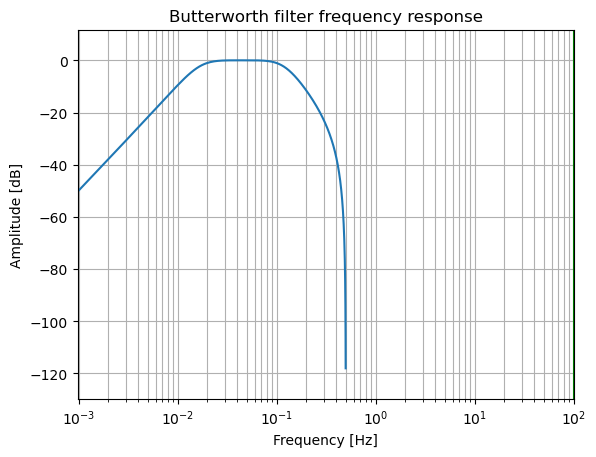

In [14]:
from scipy import signal

fs = 64
two_pi = 2*np.pi

lo_cutoff_Hz = 1
hi_cutoff_Hz = 8

sos = signal.butter(
    N = 2,
    Wn = [lo_cutoff_Hz, hi_cutoff_Hz],
    btype = 'bandpass',
    analog = False,
    output = 'sos',
    fs = fs,
)

'''
b, a = signal.butter(
    N = 2,
    Wn = [0.1, 30],
    btype = 'bandpass',
    analog = False,
    output = 'ba',
    fs = 64,
)
'''

# Freq response 
# code from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
#ω, h = signal.freqs(b, a)

plt.figure()

ω, h = signal.sosfreqz(sos)
plt.semilogx(ω/two_pi, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [15]:
# Try different BPF settings to try and improve EOG event detection 

def ica_find_eog_events_custom(raw_trials, subjectID, trialIdx, source, l_freq, h_freq):
    
    #print(f'[{trialIdx}] from {raw_trials[subjectID]}')
    
    raw = raw_trials[subjectID][trialIdx-1]

    # Find EOG events frop top IC
    ica_eog_event_id = 3
    ica_eog_events = mne.preprocessing.ica_find_eog_events(
        raw,
        eog_source = source,
        event_id = ica_eog_event_id,
        l_freq = l_freq,
        h_freq = h_freq,
        verbose='ERROR',
        #ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
    )

    return ica_eog_events

from scipy.signal import find_peaks

def find_peaks_from_ica_source(
    eog_source,
    fs = 64,
    height = 0.5,
    distance = 32,
    bpf = True,
    l_freq = 1,
    h_freq = 10,
    order = 2,
):
    # Normalize eog source
    max_peak = np.max(eog_source)
    min_peak = np.min(eog_source)
    if np.abs(min_peak) > np.abs(max_peak):
        eog_source /= min_peak # normalize, flip polarity
    else:
        eog_source /= max_peak # normalize

    if bpf:
        sos = signal.butter(
            N = order,
            Wn = [l_freq, h_freq],
            btype = 'bandpass',
            analog = False,
            output = 'sos',
            fs = fs,
        )
        eog_source = signal.sosfiltfilt(sos, eog_source)

    # Find peaks
    ica_eog_events, _ = find_peaks(
        eog_source,
        height = height, 
        distance = distance, # could miss double blinks 
    )

    return ica_eog_events

# Run peak-finder on top EOG IC
TODO: see if this improves blink detection?

In [16]:
LOAD_FILTERED_BLINKS = False
MAKE_PLOTS = False

if LOAD_FILTERED_BLINKS:
    eog_peaks = np.load('eog_peaks_21subs_bpf.npy', allow_pickle=True)
    eog_peaks = eog_peaks.flat[0]

else:    
    CUSTOM_BPF = False
    USE_PEAK_FINDER = True
    UPDATE_EOG_PEAKS = True

    # Plot and add an offset for each trial
    t = np.arange(start=0, stop=1803, step=1)

    for subjectID in eog_peaks:
        if MAKE_PLOTS:
            plt.figure(figsize=(8, 48))
            pltIdx = 1

        # Path to data for selected subject
        sub1_mat = loadmat(dataDir+f"/dataCND/dataSub{subjectID}.mat", simplify_cells = True) 

        # Randomized trial order for current subject
        orig_trial_pos = sub1_mat['eeg']['origTrialPosition']
        #print(f'orig_trial_pos shape: {orig_trial_pos.shape}')

        # Get current subject's song and condition ordering (since its randomized)
        thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
        thisSubCondOrder = condIdxs[(orig_trial_pos-1)]
        #print(f'Subject{subjectID} stim order: {thisSubStimOrder}')
        #print(f'Subject{subjectID} cond order: {thisSubCondOrder}')
        

        for stimIdx in [1, 2, 3, 4]: # top to bottom on the sheet music
            stimLabel = stimId_to_Song_map[stimIdx]

            for condIdx in [1, 2]:
                condLabel = condId_to_State_map[condIdx]

                # Find trials matching this song and condition
                trialsToEpoch = np.where(
                    (thisSubStimOrder == stimIdx) & (thisSubCondOrder == condIdx)
                )[0]

                trials_to_plot = trialsToEpoch # idxs[condLabel][stimLabel]

                if MAKE_PLOTS:
                    # Plot Fp1 data for these trials
                    plt.subplot(8, 1, pltIdx)

                offset = 0
                N_avg = 11
                source_avg = np.zeros_like(t, dtype='float64')
                
                for trialIdx in trials_to_plot:
                    source = eog_peaks[subjectID][trialIdx]['source']

                    if CUSTOM_BPF == True:
                        ica_eog_events = ica_find_eog_events_custom(
                            raw_trials, 
                            subjectID, 
                            trialIdx, 
                            source,
                            l_freq = 1,
                            h_freq = 3,
                        )
                    elif USE_PEAK_FINDER:
                        ica_eog_events = find_peaks_from_ica_source(
                            source,    
                            height = 0.25,
                            distance = 20, # assuming half_width = 10 below
                            l_freq = 1,
                            h_freq = 8,
                            order = 2,
                        )
                    else:
                        ica_eog_events = eog_peaks[subjectID][trialIdx]['ica_eog_events']

                    if UPDATE_EOG_PEAKS:
                        eog_peaks[subjectID][trialIdx]['ica_eog_events'] = ica_eog_events

                    # print(t)

                    if MAKE_PLOTS:
                        # plt.plot(fp1_data_hp + offset -1)
                        ic_trace, = plt.plot(
                            t,
                            source + offset,
                            linewidth = 0.5,
                        )
                        
                        plt.plot(
                            t[ica_eog_events], 
                            source[ica_eog_events] + offset, 
                            '*',
                            color = ic_trace.get_color())

                    offset += 1 # increment offset for next run

                    # Average
                    source_avg += source / N_avg

                offset = 12
                if MAKE_PLOTS:
                    # Plot the average
                    # print(fp1_avg)
                    plt.plot(10 * source_avg + offset, label='scaled avg')

                    # Plot the note onsets
                    plt.plot(offset * note_onsets, 'r', 
                            label='note', 
                            alpha=0.2,
                            linewidth=1
                            ) # 1 = expectations

                    # Plot metronome hits (could overlap with some notes)
                    plt.plot(offset * cueExp, 
                            'r', 
                            label='bar', 
                            alpha=0.5,
                            linewidth=1
                            )

                    condName = condId_to_State_map[condIdx]
                    stimName = stimId_to_Song_map[stimIdx]

                    title_str = '' #'='*50 + '\n'
                    title_str += f'Subject {subjectID}: top EOG IC across trials\n'
                    title_str += f'Task [{condIdx}]: {condName}\n'
                    title_str += f'Stim [{stimIdx}]: {stimName}\n'
                    title_str += f'Trials: {trials_to_plot}'
                    plt.title(title_str)

                    plt.xlabel('Time [Samples]')
                    plt.ylabel('Trial #')
                    plt.legend(loc='upper right', prop={'size': 6}) #, bbox_to_anchor=[1.5, 0.5])
                    #print(title_str)

                    pltIdx += 1

        if MAKE_PLOTS:
            plt.tight_layout()

In [17]:
SAVE_FILTERED_BLINKS = False
if SAVE_FILTERED_BLINKS:
    filename = eog_peaks_filename.split('.npy')[0] + '_bpf.npy'
    np.save(filename, eog_peaks)

# Compare blink events before/after filtering

In [18]:
# TODO

## Read in images of the score

In [19]:
if 0:
    import matplotlib.image as mpimg
    import matplotlib as mpl 

    # from stackexchange
    imgs = {}

    start_px = 50
    for bar in range(8):
        img = mpimg.imread('data/Score.png')
        
        stop_px = start_px + 70
        imgs[bar] = img[start_px:stop_px, 10:-15].copy()
        
        # offset to the next bar
        start_px += 100
        if bar%2 == 1:
            start_px += 100
            
    %matplotlib widget 

    for bar in range(8):
        plt.figure()
        plt.imshow(imgs[bar])
        plt.show()

Examine eog_peaks structure as loaded from .npy object:

In [20]:
sub = 1 # [1, 3, 7, 11]
condLabel = 'Imagery'
stimLabel = 'chor-019'

trials = idxs[condLabel][stimLabel] # [2, 8, 14, 15, 26, 27, 29, 36, 47, 48, 52, 3, 6, 11, 28, 33, 34, 37, 51, 58, 62, 70, 7, 10, 21, 23, 30, 35, 38, 39, 66, 74, 86, 12, 17, 24, 44, 45, 49, 54, 55, 56, 64, 76, 18, 19, 31, 32, 41, 57, 61, 69, 79, 84, 87, 1, 25, 42, 43, 46, 59, 60, 67, 68, 73, 85, 0, 13, 16, 22, 40, 63, 71, 75, 77, 78, 83, 4, 5, 9, 20, 50, 53, 65, 72, 80, 81, 82])

for trial in trials:
    blinks = eog_peaks[sub][trial]['ica_eog_events']
    print(trial, blinks)

77 [ 540 1016 1402]
78 [ 360  582 1183]
79 [ 258  589  788 1047 1575]
80 [ 271  609  841 1148 1368 1578]
81 [ 926 1056 1238 1777]
82 [ 316  861 1318 1510]
83 [ 339  740 1173 1524]
84 [ 20 698 940]
85 [  92  341  718 1136 1514]
86 [ 358  703 1498]
87 [ 261  413  575  872 1203 1337]


# Info Theory Metric

In [21]:
condId_to_State_map

{1: 'Listening', 2: 'Imagery'}

In [22]:
stimLabel_to_id_map.keys()

dict_keys(['chor-038', 'chor-096', 'chor-101', 'chor-019'])

# Coding Cost with Poisson Distributed Blinks

We first bin the blink events from every $N$ time-stamps long trial $t$ into $B$ sized bins. Here, $B$ is a hyperparameter representing the redundancy in blink timings, which we will tune to analyze whether a particular time-scale best represents the song identity in subjects' blink timing. 

The binning exercies gives us a binned-blinks series $b_{k,t}$ for the total blinks assigned to the $k^\text{th}$ bin on the $t^\text{th}$ trial, with a bin-size of $\frac{N}{B}$ time samples.

Since $b_{k,t}$ is a blink count and can take integer values, we fit a Poisson random variable $X_k$ to every $k^{th}$ bin representing the probability $p_k$ of blinking $b_k$ times over the $T$ trials (with one trial left out, so $T=11-1=10$):

$
p_k = f(b_k; \lambda_k) = Pr(X_k = b_k) = \frac{\lambda_k ^ {b_k}}{b_k !}e^{-{\lambda_k}}
$

Here, 
$
\lambda_k =\frac{1}{T}\sum_{t=1}^{T}{b_{k,t}}
$

Now, let $s_k$ represent the binned-blinks from the one left out trial.

We thus calculate the coding cost of representing $s_k$ using the Poisson distributions $p_k$ we fitted to the $T$ trials above as:

$
C = -\sum_{k=1}^{N} \left[ 
    s_k log_2(p_k) + (1-s_k) log_2(1-p_k) 
    \right]
$

As a baseline comparison, we also fit a Poisson distribution $q_k$ using the average blink rate of the subject over the $T$ training trials:

$
q_k = f(b_k; \Lambda) = Pr(X_k = b_k) = \frac{\Lambda ^ {b_k}}{b_k !}e^{-{\Lambda}}
$, where

$
\Lambda 
= \frac{1}{T}\sum_{t=1}^{T} \left(
\frac{1}{N} \sum_{k=1}^{N}{b_{k,t}}
\right)
$

$p_k - q_k$ then represents any reduction in cost for coding $q_k$ using the trained distribution $p_k$, as compared to just the baseline distribution $q_k$ where the subject was equally likely to blink over all bins. 

Then we repeat this calculation for all combinations of subjects, conditions, and songs, giving us a matrix:

$
\textbf{A}_{i, j} = \left[
    p_{k, i} - q_{k, j}
\right]
$

## Bin the blinks

TODO: replace with an actual convolution

In [23]:
def bin_blinks( # update to use a convolution
        t, 
        peaks, 
        bin_width = int(64/(100/60)), # qtr note
    ):

    t_peaks = np.zeros_like(t)
    t_peaks[peaks] = 1

    bins = [e for e in range(0, len(t), bin_width)] # these bins will be uniformly sized
    #if bins[-1] < t[-1]: # we have some time left that can become a shorter bin
    #    bins.append(t[-1])
        
    blinks = np.add.reduceat(t_peaks, bins) # https://stackoverflow.com/a/29391999
    
    return bins, blinks

# Figure out binning method
if 0:
    a = np.zeros(shape=(100,))
    a[np.random.rand(len(a)) > 0.9] = 1

    bps = 100/60

    # (samples/s)/(beats/s) = samples/beat, 1 beat = 1/4 note
    BIN_SIZE = int(fs/bps) # qtr note
    print(BIN_SIZE)

    bins = range(0, len(a), BIN_SIZE) # can be non-uniform bin sizing
    print(bins)

    b = np.add.reduceat(a, bins) # https://stackoverflow.com/a/29391999

    bb = []
    aa = np.copy(a)
    for i in range(len(bins)):
        if i == len(bins) -1:
            b_in_bin = aa[bins[i]:] # last bin could be smaller than BIN_SIZE
        else:
            b_in_bin = aa[bins[i]:bins[i+1]]
        bb.append(sum(b_in_bin))

    assert (b == bb).all()

## Fit Poisson

In [24]:
def fit_λ(binned_blinks_all_trials):

    # Get number of trials (rows)
    T, _ = binned_blinks_all_trials.shape
    #print(T)
    
    # Fit λ
    λ = np.sum(binned_blinks_all_trials, axis=0) / T # average blinks per bin
    
    # Probability of blinking atleast once during a bin interval
    #p_blinked = 1 - np.exp(-λ) # https://stats.stackexchange.com/q/306915
    #return p_blinked

    return λ

TODO:
- Should bin sizing be adjusted to account for +/- shifts in cue (beat) locations from bar to bar?
- Should we also plot rest events? And then attempt to decode music of silence pt.2?

## Duration of a quarter note in #samples (for timescales)

In [25]:
n_quarter_note = int(fs_Hz / bps)
print(n_quarter_note)

38


In [26]:
%load_ext blackcellmagic

In [27]:
def binned_blinks_for_matching_trials(
    eog_peaks,
    subjectID,
    bin_width,
    stimLabel,
    condLabel,
    t,
    idxs,
    print_out = False,
):
    matching_trials = idxs[condLabel][stimLabel]

    trialCnt = 0
    trialOrder = []
    for trialIdx in eog_peaks[subjectID]:
        if trialIdx in matching_trials:
            peaks = eog_peaks[subjectID][trialIdx]["ica_eog_events"]
            # print(peaks)

            bins, binned_blinks = bin_blinks(t, peaks, bin_width)
            if print_out:
                print(f"#bins: {len(bins)}\tb_k shape: {binned_blinks.shape}")
                print(bins, binned_blinks)

            if trialCnt == 0:  # first iteration
                binned_blinks_all_trials = np.copy(binned_blinks)
            else:
                binned_blinks_all_trials = np.vstack(
                    (binned_blinks_all_trials, binned_blinks)
                )

            if print_out:
                print(binned_blinks_all_trials.shape)

            trialCnt += 1
            trialOrder.append(list(eog_peaks[subjectID].keys()).index(trialIdx))

    return bins, binned_blinks_all_trials, trialOrder

In [28]:
def plot_binned_blinks_prob(
    eog_peaks, subjectID, # to get peaks
    t, stim, condLabel, stimLabel, 
    bin_width,
    bins, binned_blinks_all_trials, trialOrder,
    p_blinked,
    fs_Hz,
):

    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot notes and beats
    notes = t[stim[stimLabel]["notes"]]
    beats = t[stim[stimLabel]["beats"] > 0]

    ax.plot(
        t[notes] / fs_Hz,
        0 * t[notes] + len(trialOrder) + 1,
        ".",
        label="Note",
    )
    ax.plot(
        t[beats] / fs_Hz,
        0 * t[beats] + len(trialOrder) + 1,
        "o",
        label="Tactile Cue",
    )

    trialCnt = 0
    stimIdxs = list(eog_peaks[subjectID].keys())
    trialStimIdxs = [stimIdxs[i] for i in trialOrder]
    
    for trialStimIdx in trialStimIdxs:
        binned_blinks = binned_blinks_all_trials[trialCnt, :]
        peaks = eog_peaks[subjectID][trialStimIdx]["ica_eog_events"]
        print(subjectID, trialStimIdx, peaks)
        
        # Plot the binned blink counts
        ## First add one more bin edge for the last step
        x = t[bins] / fs_Hz
        x = np.append(x, t[-1] / fs_Hz)
        y = binned_blinks / 4 + trialCnt
        y = np.append(y, y[-1])

        line, = ax.step(  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.step.html
            x=x,
            y=y,
            where="post",  # [x[i], x[i+1]) has the value y[i]
        )

        # Draw a line representing the trial
        ax.axhline(
            y=trialCnt,
            ls="--",
            c="k",
            lw=0.5,
            alpha=0.3,
        )

        # Plot the actual blinks for reference
        ax.plot(
            t[peaks] / fs_Hz,
            0 * t[peaks] + trialCnt,
            "x",
            c=line.get_color(),
        )

        trialCnt += 1

    # Draw bin boundaries
    for t_bin in t[bins]:
        ax.axvline(
            x=t_bin / fs_Hz,
            ls="--",
            c="k",
            lw=0.5,
            alpha=0.3,
        )

    # Twin axis for probability plot
    axp = ax.twinx()

    # Draw prob on a separate y-axis
    bars = axp.bar(
        x=(t[bins] + bin_width / 2) / fs_Hz,
        height=p_blinked,
        width=bin_width / fs_Hz,
        alpha=0.1,
        label="Probability of Blinking"
        # where = 'post', # [x[i], x[i+1]) has the value y[i]
    )

    # Formatting
    ax.set_xlabel("Time [seconds]")
    ax.set_yticks(range(0, 11))
    ax.set_yticklabels(trialOrder)
    ax.set_ylabel("Trial #")
    ax.legend(
        # loc='upper right',
        ncols=2,
        bbox_to_anchor=[0.375, -0.05],
    )

    bin_qtr_notes = bin_width / (fs_Hz / bps)
    title_str = f"Subject {subjectID}, {condLabel}, {stimLabel}\n"
    title_str += "Bin Size = {:.2f} x 1/4 notes = {:.3f} seconds".format(
        bin_qtr_notes, bin_width / fs
    )
    ax.set_title(title_str)

    ax.set_xlim([0, t[-1] / fs_Hz])

    #axp.set_ylim([0, 1])
    axp.legend(bbox_to_anchor=[1.01, -0.05])
    axp.tick_params(axis="y")  # , colors=bars[0].get_facecolor()) #, alpha=1)
    #axp.set_ylabel("Pr[$b_k > 0$]", color=bars[0].get_facecolor(), alpha=1)
    axp.set_ylabel("$\lambda_i$", color=bars[0].get_facecolor(), alpha=1)

1 14 [  66  200  577  865 1024 1176 1346 1744]
1 15 [ 116  194  419  577  855 1141 1289 1491]
1 11 [ 676  696  833 1304]
1 21 [  79  235  446  593  746  975 1045 1345 1520 1732]
1 12 [  70  289  552  817 1047 1299]
1 17 [  79  222  431  654  859 1037 1334 1770]
1 18 [  91  277  568  707 1343 1487 1590]
1 19 [ 152  454  801 1194 1362 1494 1683]
1 13 [  91  197  293  544  752  997 1120 1343 1746 1772 1797]
1 16 [ 102  234  541  870 1157 1799]
1 20 [  83  204  351  567  743  858 1006 1140 1339 1667 1720 1756 1791]
1 58 [ 201  349  839 1036 1301 1597]
1 62 [ 139  251  390  486  548  657  798  873 1030 1128 1281 1420 1714]
1 55 [  74  219  506  646  864 1123 1297 1340]
1 56 [ 202  284  651  758 1002 1128 1260 1774]
1 64 [  53  223  540  711  881 1162 1308 1425]
1 57 [  82  220  401  510  697  821 1151 1325 1444]
1 61 [ 106  399  488  786  952 1117 1272 1403 1622 1797]
1 59 [ 209  476  730  902 1033 1351 1572 1798]
1 60 [ 235  474  693  872 1089 1261 1417 1587]
1 63 [ 239  490  652 1118 1141

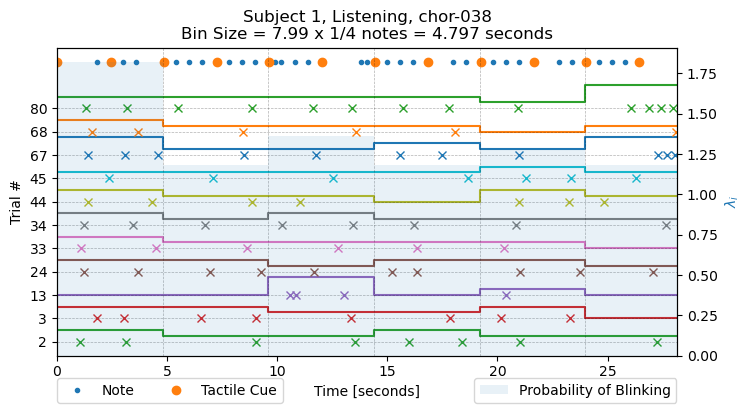

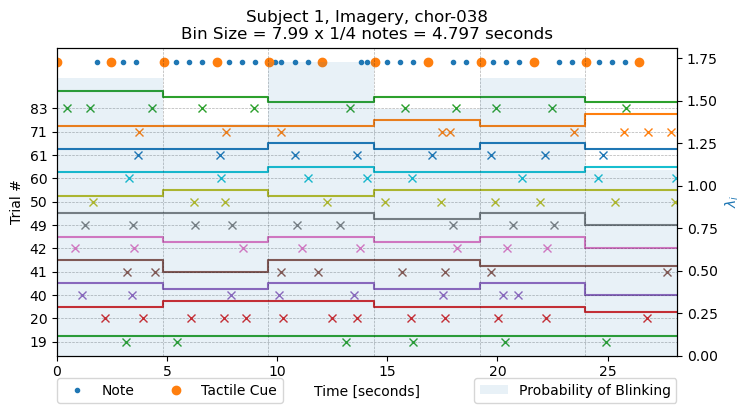

In [29]:
if 1:
    bin_qtr_notes = 8 # number of quarter notes to fit into one bin 
    bin_width = int(bin_qtr_notes * fs_Hz/bps) # qtr note

    t = np.arange(start=0, stop=len(cueExp), step=1)

    peaks_sq_all = {}
    for subjectID in [1]: #eog_peaks:
        peaks_sq_all[subjectID] = {}
        
        for stimIdx in [2]: #, 2, 3, 4]: # top to bottom on the sheet music
            stimLabel = stimId_to_Song_map[stimIdx]
            peaks_sq_all[subjectID][stimLabel] = {}
            
            for condIdx in [1, 2]:
                condLabel = condId_to_State_map[condIdx]
                peaks_sq_all[subjectID][stimLabel][condLabel] = {}

                bins, binned_blinks_all_trials, trialOrder = binned_blinks_for_matching_trials(
                    eog_peaks = eog_peaks,
                    subjectID = subjectID, 
                    bin_width = bin_width, 
                    stimLabel = stimLabel, 
                    condLabel = condLabel,
                    t = t, 
                    idxs = idxs,
                )

                # Fit λ and get prob. from Poisson
                p_blinked = fit_λ(binned_blinks_all_trials)

                plot_binned_blinks_prob(
                    eog_peaks = eog_peaks, 
                    subjectID = subjectID, # to get peaks
                    t = t, 
                    stim = stim, 
                    stimLabel = stimLabel, 
                    condLabel = condLabel,
                    bin_width = bin_width,
                    bins = bins, 
                    binned_blinks_all_trials = binned_blinks_all_trials, 
                    trialOrder = trialOrder,
                    p_blinked = p_blinked,
                    fs_Hz = fs_Hz,
                )

                # Trying numpy arrays combining all trials (instead of 11x dict items)
                peaks_sq_all[subjectID][stimLabel][condLabel] = binned_blinks_all_trials

In [30]:
if 0: # backup, before splitting into functions
    
    bin_qtr_notes = 4 # number of quarter notes to fit into one bin 
    bin_width = int(bin_qtr_notes * fs_Hz/bps) # qtr note

    t = np.arange(start=0, stop=len(cueExp), step=1)

    peaks_sq_all = {}
    for subjectID in [1]: #eog_peaks:
        peaks_sq_all[subjectID] = {}
        
        for stimIdx in [2]: #, 2, 3, 4]: # top to bottom on the sheet music
            stimLabel = stimId_to_Song_map[stimIdx]
            peaks_sq_all[subjectID][stimLabel] = {}
            
            notes = t[stim[stimLabel]['notes']]
            beats = t[stim[stimLabel]['beats']>0]

            for condIdx in [1, 2]:
                condLabel = condId_to_State_map[condIdx]
                peaks_sq_all[subjectID][stimLabel][condLabel] = {}

                matching_trials = idxs[condLabel][stimLabel]
                    
                fig, ax = plt.subplots(figsize=(8, 4))
                axp = ax.twinx()

                # Plot notes and beats
                ax.plot(
                    t[notes]/fs_Hz, 
                    0*t[notes] + len(trials_to_plot)+1, 
                    '.', label='Note')
                ax.plot(
                    t[beats]/fs_Hz, 
                    0*t[beats] + len(trials_to_plot)+1, 
                    'o', label='Tactile Cue')
                
                trialCnt = 0
                trialOrder = []
                for trialStimIdx in eog_peaks[subjectID]:
                    if trialStimIdx in matching_trials:
                        peaks = eog_peaks[subjectID][trialStimIdx]['ica_eog_events']
                        print(f'subjectID={subjectID}, trialIdx={trialStimIdx}, peaks={peaks}')

                        bins, binned_blinks = bin_blinks(t, peaks, bin_width)
                        print(f'#bins: {len(bins)}\tb_k shape: {binned_blinks.shape}')
                        print(bins, binned_blinks)

                        if trialCnt == 0: # first iteration
                            binned_blinks_all_trials = np.copy(binned_blinks)
                        else:
                            binned_blinks_all_trials = np.vstack(
                                    (binned_blinks_all_trials, binned_blinks)
                            )
                        print(binned_blinks_all_trials.shape)
                        
                        # Plot the binned blink counts 
                        ## First add one more bin edge for the last step
                        x = t[bins]/fs_Hz
                        x = np.append(x, t[-1]/fs_Hz)
                        y = binned_blinks/4 + trialCnt
                        y = np.append(y, y[-1])
                        line, = ax.step( # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.step.html
                            x = x,
                            y = y,
                            where = 'post', # [x[i], x[i+1]) has the value y[i]
                        )

                        # Draw a line representing the trial
                        ax.axhline(
                            y=trialCnt, 
                            ls='--', c='k', lw=0.5, alpha=.3,
                        )
                        
                        # Plot the actual blinks for reference
                        ax.plot(
                            t[peaks]/fs_Hz, 
                            0*t[peaks] + trialCnt, 
                            'x', c=line.get_color(),
                        )

                        trialCnt += 1
                        trialOrder.append(list(eog_peaks[subjectID].keys()).index(trialStimIdx))
                
                # Draw bin boundaries
                for t_bin in t[bins]:
                    ax.axvline(
                        x=t_bin / fs_Hz, 
                        ls='--', c='k', lw=0.5, alpha=.3)

                # Trying numpy arrays combining all trials (instead of 11x dict items)
                peaks_sq_all[subjectID][stimLabel][condLabel] = binned_blinks_all_trials
                
                # Fit λ and get prob. from Poisson
                p_blinked = fit_λ(binned_blinks_all_trials)
                print(len(p_blinked))

                # Draw prob on a separate y-axis
                bars = axp.bar(
                    x = (t[bins] + bin_width/2)/fs_Hz,
                    height = p_blinked,
                    width = bin_width/fs_Hz,
                    alpha = 0.1,
                    label = 'Probability of Blinking'
                    #where = 'post', # [x[i], x[i+1]) has the value y[i]
                )
                
                # Formatting
                ax.set_yticks(range(0, 11))
                ax.set_yticklabels(trialOrder)
                ax.set_xlabel('Time [seconds]')
                ax.set_ylabel('Trial #')
                ax.legend(
                    #loc='upper right',
                    ncols=2,
                    bbox_to_anchor = [0.375, -.05]
                )
                title_str = f'Subject {subjectID}, {condLabel}, {stimLabel}\nBin Size = {bin_qtr_notes} x 1/4 notes = ' + '{:.3f} seconds'.format(bin_width/fs)
                ax.set_title(title_str)
                ax.set_xlim([0, t[-1]/fs_Hz])
                axp.set_ylim([0, 1])
                axp.legend(
                    bbox_to_anchor = [1.01, -.05]
                )
                axp.tick_params(axis="y") #, colors=bars[0].get_facecolor()) #, alpha=1)
                axp.set_ylabel('Pr[$b_k > 0$]', color=bars[0].get_facecolor(), alpha=1)

## Coding Cost

$
f(x_i; \lambda_i) = Pr(X_i = x_i) = \frac{\lambda_i ^ {x_i}}{b_i !}e^{-{\lambda_i}}
$

$
C = -\sum_{i} 
\text{ln}
\left( 
    \frac{\lambda_i^{x_i}}{x_i!} e^{-\lambda_i}
\right)
$

In [89]:
def coding_cost(
        λ, x,
        SMALL_NUMBER = 1e-20, #np.nextafter(0, 1)
        SQ_SANITY_CHECK = False,
        log = np.log2,
        NORM_NUM_BLINKS = False
    ):

    #λ += SMALL_NUMBER
    #x += SMALL_NUMBER
    x = np.float64(x) # cast to float

    N = λ.size
    assert λ.size == x.size

    if NORM_NUM_BLINKS:
        # use the number of blinks in lambda as reference, since its more data
        λmean = np.mean(λ)
        xmean = np.mean(x)
        #if np.sum(x) != 0:
        #    x *= λmean / xmean
        if λmean != 0:
            λ *= xmean / λmean
            if xmean == 0:
                print('xmean = 0 => lambda_norm = 0')

    info = 0
    for i in range(N):
        λ_i = λ[i]
        x_i = x[i] 
        if SQ_SANITY_CHECK:
            info += (λ_i - x_i)**2
        else:
            arg = (λ_i ** x_i)/np.math.factorial(int(x_i))
            arg *= np.exp(-λ_i)
            info += -log(arg, where=arg>0) # else adds 0
            
    info /= N
    return info, λ, x

# testing
N_test = 10 # 10 time stamps
λ_test = 0.5 * np.ones(shape=(N_test,))
x_test = np.ones(shape=(N_test,))
x_test[np.random.rand(N_test) < 0.8] = 0 

# λ vs. x
print(coding_cost(
    λ_test, x_test,
    log = np.log2,
    NORM_NUM_BLINKS = False,
    ), λ_test, x_test)

# λ vs. x_norm
print(coding_cost(
    λ_test, x_test, 
    log = np.log2,
    NORM_NUM_BLINKS = True,
    ), λ_test, x_test)

# x vs. x
print(coding_cost(
    x_test, x_test, 
    log = np.log2,
    NORM_NUM_BLINKS = False,
    ), x_test, x_test)

# x vs. x_norm (should be the same)
print(coding_cost(
    x_test, x_test, 
    log = np.log2,
    NORM_NUM_BLINKS = True,
    ), x_test, x_test)

#print(coding_cost(p_test, q_test, SQ_SANITY_CHECK=True))
#print(coding_cost(λ_test, x_test, log = np.log))
#print(coding_cost(x_test, x_test, log = np.log))

(0.9213475204444818, array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0.7529246271552651, array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])) [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2] [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0.28853900817779266, array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])) [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0.28853900817779266, array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])) [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Split training ($λ$) and test ($x$) trials

To Do:
- Split p/q 5:5, keep one trial aside for decoding testing
- Compare coding cost against a uniform p (flat blink prob across of 1/1803)

In [129]:
PLOT_DISTROS = not True # visualize p and q distros
SQ_SANITY_CHECK = False 

subjectIDs = eog_peaks.keys() #[1]
NUM_SUBJECTS = len(subjectIDs)
TEST_STIM_LABELS = ['chor-038', 'chor-096', 'chor-101', 'chor-019']
condLabels = ['Listening', 'Imagery'] #['Listening'] # consider only listening

#NUM_TRAINING_TRIALS = 10
#NUM_TESTING_TRIALS = 1 # leave one trial out

TIMESCALES = [
    int(n_quarter_note/4),  # 1/16 bar
    int(n_quarter_note),    # 1/4
    int(n_quarter_note*4),  # 1 bar
    int(n_quarter_note*16), # 4 bars
]
'''
n_quarter_note/2,   # 1/8
n_quarter_note*2,   # 1/2
n_quarter_note*4,   # 1
n_quarter_note*8,   # 2
'''

bin_width_sweep = [] #collects corresponding half width durations
all_bins = {}
t = np.arange(start=0, stop=len(cueExp), step=1)

AVG_LOOPS = 11 # 10 # 100
train_trial_avg = {}
test_trial_avg = {} # data for test set?

for bin_width in TIMESCALES:
    bin_width_sweep.append(bin_width)
    
    if not bin_width in train_trial_avg:
        train_trial_avg[bin_width] = {}
        test_trial_avg[bin_width] = {}

    if PLOT_DISTROS:
        # new plot for each bin size
        fig, ax = plt.subplots(
            len(subjectIDs)*len(condLabels), 
            len(TEST_STIM_LABELS), 
            sharey=True,
            figsize=(6, 12),
        ) #figsize = (30, 70*NUM_SUBJECTS))
        pltIdx = 0

    for subjectID in subjectIDs: #allTrialsForNullDistro:
        if not subjectID in train_trial_avg[bin_width]:
            train_trial_avg[bin_width][subjectID] = {}
            test_trial_avg[bin_width][subjectID] = {}

        for condLabel in condLabels:
            if not condLabel in train_trial_avg[bin_width][subjectID]:
                train_trial_avg[bin_width][subjectID][condLabel] = {}
                test_trial_avg[bin_width][subjectID][condLabel] = {}
            
            for stimLabel in TEST_STIM_LABELS:

                # Split trials into train-test sets
                allMatchingTrials = [x for x in range(11)]

                bins, binned_blinks_all_matching_trials, trialOrder = binned_blinks_for_matching_trials(
                    eog_peaks = eog_peaks,
                    subjectID = subjectID, 
                    bin_width = bin_width, 
                    stimLabel = stimLabel, 
                    condLabel = condLabel,
                    t = t, 
                    idxs = idxs,
                )
                all_bins[bin_width] = bins
                #print('bins', bins)
                
                for n_loop in range(AVG_LOOPS):
                    #print(f'n_loop: {n_loop}')
                    #np.random.shuffle(allMatchingTrials)
                    #print('All trials:', allMatchingTrials)
                    trainTrialIdxs = list(set(allMatchingTrials) - set([n_loop]))
                    #print('Train trials:', trainTrialIdxs)
                    
                    testTrialIdxs = allMatchingTrials[n_loop] #NUM_TRAINING_TRIALS:NUM_TRAINING_TRIALS + NUM_TESTING_TRIALS]
                    #print('Test trials:', testTrialIdxs)
                    

                    # Fit λ and get prob. from Poisson
                    # Training trials
                    p_blinked = fit_λ(binned_blinks_all_matching_trials[trainTrialIdxs, :])
                    if np.sum(p_blinked) == 0:
                        print(f'lambda=0 for bin_width={bin_width}, sub-{subjectID}, {stimLabel}, {condLabel}')
                    #p_blinked = p_blinked[:, np.newaxis]
                    
                    # Test trial
                    q_blinked = binned_blinks_all_matching_trials[testTrialIdxs, :]
                    #q_blinked = q_blinked[:, np.newaxis]

                    # Concatenate
                    if n_loop == 0:
                        p_blinked_loops = np.copy(p_blinked)
                        q_blinked_loops = np.copy(q_blinked)
                    else:
                        p_blinked_loops = np.vstack(
                            (p_blinked_loops, p_blinked)
                        )
                        q_blinked_loops = np.vstack(
                            (q_blinked_loops, q_blinked)
                        )
                
                train_trial_avg[bin_width][subjectID][condLabel][stimLabel] = np.copy(p_blinked_loops)
                test_trial_avg[bin_width][subjectID][condLabel][stimLabel] = np.copy(q_blinked_loops)

                if PLOT_DISTROS:
                    notes = t[stim[stimLabel]['notes']]
                    beats = t[stim[stimLabel]['beats']>0]

                    #if AVG_LOOPS == 1:
                    #    p = p_blinked_loops
                    #    q = q_blinked_loops
                    #else:
                    λ = p_blinked_loops[n_loop, :]
                    x = q_blinked_loops[n_loop, :]
                    
                    cost, λ_norm, x_norm = coding_cost(
                        λ, x, 
                        SQ_SANITY_CHECK=SQ_SANITY_CHECK,
                        NORM_NUM_BLINKS = True,
                    )

                    pltIdx += 1
                    ax = plt.subplot(len(subjectIDs) * len(condLabels), 4, pltIdx)

                    # Draw prob on a separate y-axis
                    train_bars = ax.bar(
                        x=(t[bins] + bin_width / 2) / fs_Hz,
                        height=λ_norm,
                        width=bin_width / fs_Hz,
                        alpha=0.3,
                        label="Probability of Blinking (Train)"
                        # where = 'post', # [x[i], x[i+1]) has the value y[i]
                    )
                    test_bars = ax.bar(
                        x=(t[bins] + bin_width / 2) / fs_Hz,
                        height=x_norm,
                        width=bin_width / fs_Hz,
                        alpha=0.3,
                        label="Probability of Blinking (Train)"
                        # where = 'post', # [x[i], x[i+1]) has the value y[i]
                    )

                    plt.suptitle('Blink Dur: {:.3f} s'.format(bin_width / fs))
                    title_str = f'{subjectID}/{condLabel[:4]}/{stimLabel[-3:]}\n'
                    title_str += '$\sum λ = $' + '{:.2f}'.format(np.sum(λ_norm))
                    title_str += '\n'
                    title_str += '$\sum x = $' + '{:.2f}'.format(np.sum(x_norm))
                    title_str += '\n'
                    title_str += 'cost =' + '{:.2f}'.format(cost)
                    
                    #title_str+= f'\nTraining Trials\t(for $p_i$): {trainTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                    #title_str+= f'\nTest Trials\t(for $q_i$): {testTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                    #title_str+= '\n$-1/N \sum q_i log p_i + (1-q_i) log (1-p_i)$ = {:.5f}'.format(info)
                    ax.set_title(title_str)

                    ax.set_xlabel('Time [s]')
                    #ax.set_ylim([0, 4])

    if PLOT_DISTROS:
        plt.tight_layout()
        plt.show()

lambda=0 for bin_width=9, sub-18, chor-096, Listening
lambda=0 for bin_width=9, sub-18, chor-096, Imagery
lambda=0 for bin_width=38, sub-18, chor-096, Listening
lambda=0 for bin_width=38, sub-18, chor-096, Imagery
lambda=0 for bin_width=152, sub-18, chor-096, Listening
lambda=0 for bin_width=152, sub-18, chor-096, Imagery
lambda=0 for bin_width=608, sub-18, chor-096, Listening
lambda=0 for bin_width=608, sub-18, chor-096, Imagery


In [130]:
def plot_info(results_matrix, ax, rowLabels, colLabels, title= "", vmin = None, vmax=None, fontsize=4, cmap='magma'):
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    # fig, ax = plt.subplots(figsize = figsize)
    im = ax.imshow(results_matrix, cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(colLabels)), labels=colLabels)
    ax.set_yticks(np.arange(len(rowLabels)), labels=rowLabels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
            rotation_mode="anchor", fontsize=fontsize)
    '''
    # Loop over data dimensions and create text annotations.
    for i in range(N):
        for j in range(N):
            text = ax.text(j, i, results_matrix[i, j],
                        ha="center", va="center", color="w")
    '''
    ax.set_title(title)
    plt.colorbar(im) #, ax=ax)
    plt.tight_layout()
    #plt.show()

def plot_pq(ax, p, q, t, bins, fs_Hz, title_str = '', legend=False):
    #ax = plt.subplot(len(eog_peaks.keys()) * len(condLabels), 4, pltIdx)

    train_bars = ax.bar(
        x=(t[bins] + bin_width / 2) / fs_Hz,
        height=p,
        width=bin_width / fs_Hz,
        alpha=0.3,
        label="λ"
        # where = 'post', # [x[i], x[i+1]) has the value y[i]
    )
    test_bars = ax.bar(
        x=(t[bins] + bin_width / 2) / fs_Hz,
        height=q,
        width=bin_width / fs_Hz,
        alpha=0.3,
        label="x"
        # where = 'post', # [x[i], x[i+1]) has the value y[i]
    )
    if legend:
        ax.legend(bbox_to_anchor=[2, 1])
    ax.set_title(title_str)
    ax.set_xlabel('Time [s]')

In [131]:
stimId_to_Song_map

{2: 'chor-038', 1: 'chor-096', 3: 'chor-101', 4: 'chor-019'}

In [132]:
train_trial_avg.keys()

dict_keys([9, 38, 152, 608])

In [133]:
bin_width_sweep

[9, 38, 152, 608]

Group by subject:

xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
[[0.5512731  0.57182537 0.91050903 1.17310675]
 [0.5512731  0.57182537 0.91050903 1.17310675]
 [0.5512731  0.57182537 0.91050903 1.17310675]
 [0.5512731  0.57182537 0.91050903 1.17310675]]


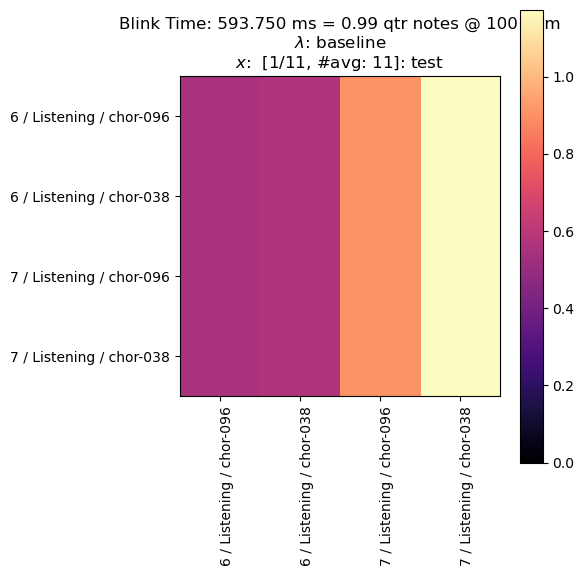

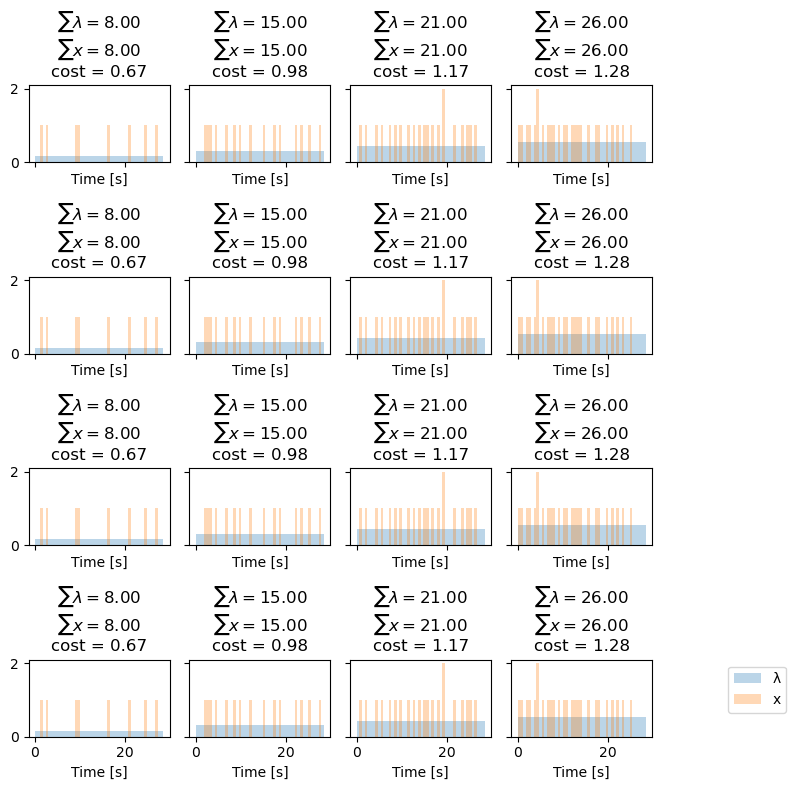

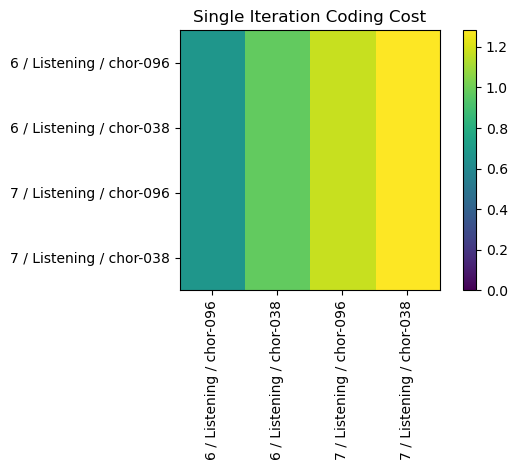

xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
xmean = 0 => lambda_norm = 0
[[0.47744932 0.47740954 0.7533643  0.99140757]
 [0.43481714 0.48085643 0.76752089 0.96413795]
 [0.56002636 0.58216641 0.85800509 1.21774156]
 [0.55293345 0.57982052 0.90238044 1.17831577]]


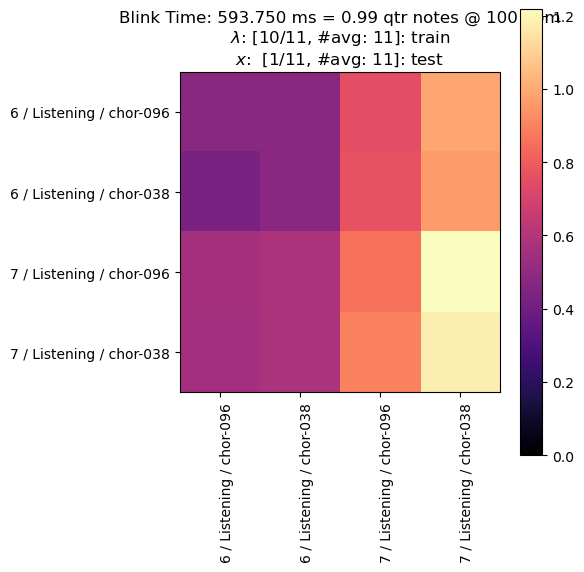

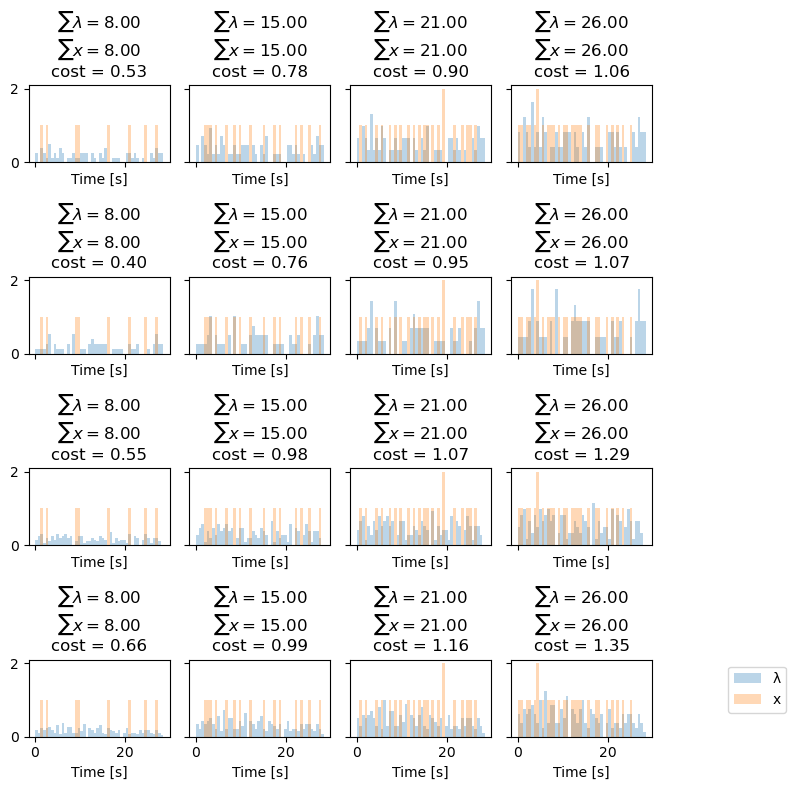

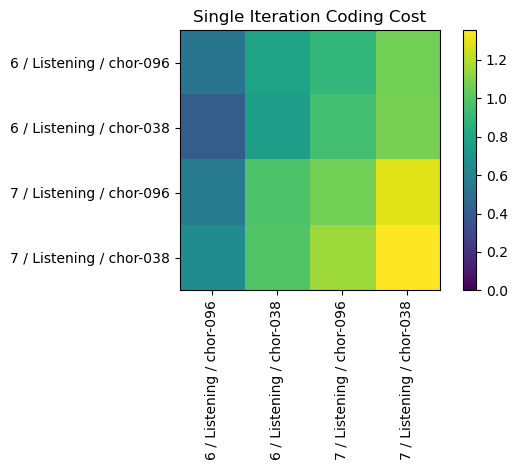

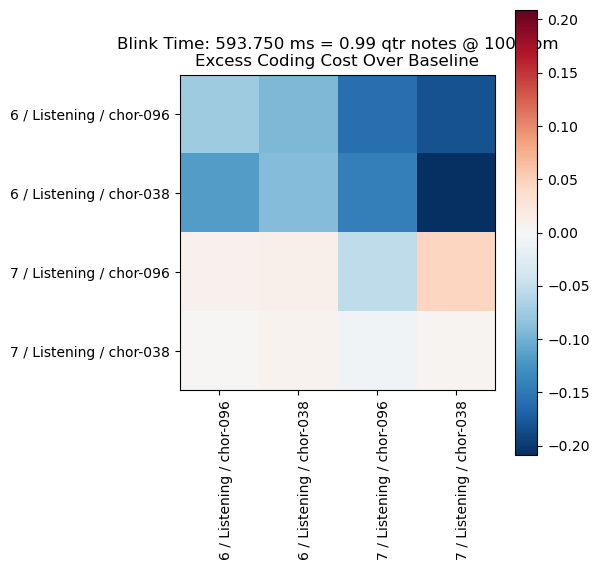

In [137]:
PLOT_λx = True

vmin = 0
vmax = None #0.04
vmin_delta = None #-2
vmax_delta = None #+2

subjectIDs = [6, 7] #[1, 6, 7, 11, 17] #[1, 6, 7, 11, 17]
bin_widths = [38] #[9, 38, 152, 608] #, 608] #, 53, 106]
condLabels = ['Listening']#, 'Imagery']
stimLabels = ['chor-038', 'chor-096'] #, 'chor-101','chor-019'] #list(train_trial_avg[bin_widths[0]][subjectIDs[0]][condLabels[0]].keys())
λ_BASELINE_CHECK = [True, False]
λ_TRAIN = True
SQ_SANITY_CHECK = not True
X_TRAIN = False

for bin_width in bin_widths:
    for NORM_NUM_BLINKS in [True]: # , False]: #[True, False]:

        N = len(subjectIDs)*len(condLabels)*len(stimLabels)
        results_matrix = np.zeros(
            shape=(N, N),
        )
        results_matrix_baseline = np.zeros(
            shape=(N, N),
        )

        for λ_BASELINE in λ_BASELINE_CHECK:        
            rowLabels = []
            colLabels = []
            λmeans = []

            if PLOT_λx:
                λ_all = {}
                x_all = {}
                λx_costs = np.zeros(
                    shape=(N, N),
                )

            for i in range(N):

                if PLOT_λx:
                    λ_all[i] = {}
                    x_all[i] = {}


                for j in range(N):

                    subjectIDi = subjectIDs[int(i / (len(condLabels)*len(stimLabels)))]
                    subjectIDj = subjectIDs[int(j / (len(condLabels)*len(stimLabels)))]

                    condLabeli = condId_to_State_map[1 + int(i / len(stimLabels))%len(condLabels)]
                    condLabelj = condId_to_State_map[1 + int(j / len(stimLabels))%len(condLabels)]

                    stimLabeli = stimId_to_Song_map[1 + i % len(stimLabels)] #% (len(subjectIDs)*len(condLabels))]
                    stimLabelj = stimId_to_Song_map[1 + j % len(stimLabels)] #% (len(subjectIDs)*len(condLabels))]

                    if i == 0:
                        colLabels.append(f'{subjectIDj} / {condLabelj} / {stimLabelj}')

                    for n_loop in range(AVG_LOOPS):
                        
                        if λ_TRAIN:
                            λ = train_trial_avg[bin_width][subjectIDi][condLabeli][stimLabeli][n_loop]
                        else:
                            λ = test_trial_avg[bin_width][subjectIDi][condLabeli][stimLabeli][n_loop]

                        if X_TRAIN:
                            x = train_trial_avg[bin_width][subjectIDj][condLabelj][stimLabelj][n_loop]
                        else:
                            x = test_trial_avg[bin_width][subjectIDj][condLabelj][stimLabelj][n_loop]
                        #print(x)

                        if λ_BASELINE:
                            λmean = np.mean(λ)
                            λmeans.append(λmean)

                            λ = λmean * np.ones_like(λ)
                            #print('baseline', λ)
                        
                        if np.sum(λ) == 0:
                            print('lambda is 0 before normalizing with xmean!')
                            print(bin_width, subjectIDi, condLabeli, stimLabeli, n_loop) 

                        cost, λ_norm, x_norm = coding_cost(
                            np.copy(λ), 
                            np.copy(x), 
                            SMALL_NUMBER=1e-20,
                            SQ_SANITY_CHECK=SQ_SANITY_CHECK,
                            NORM_NUM_BLINKS=NORM_NUM_BLINKS,
                        )

                        if 0: #np.sum(λ_norm) == 0:
                            print('lambda_norm is 0!')
                            if np.sum(x_norm) == 0: # same as x
                                print('x is also 0')
                            print(bin_width, subjectIDi, condLabeli, stimLabeli, n_loop) 
                            #print('loop#', n_loop)
                            plt.plot(λ_norm)
                            plt.plot(x_norm)
                            plt.show()

                        if λ_BASELINE:
                            results_matrix_baseline[i, j] += cost / AVG_LOOPS
                        else:
                            results_matrix[i, j] += cost / AVG_LOOPS

                        if PLOT_λx:
                            if n_loop == 0:
                                λ_all[i][j] = λ_norm #/ AVG_LOOPS
                                x_all[i][j] = x_norm #/ AVG_LOOPS
                                λx_costs[i][j] = cost

                            #else:
                            #    λ_all[i][j] += λ_norm / AVG_LOOPS
                            #    x_all[i][j] += x_norm / AVG_LOOPS

                        #print(f'{subjectID1}/{condLabel1}/{stimLabel1} vs. {subjectID2}/{condLabel2}/{stimLabel2}\t{results_matrix[i, j]}\t{p}\t{q}')

                # update after IDs have been calculated above:
                rowLabels.append(f'{subjectIDi} / {condLabeli} / {stimLabeli}')

            title = 'Blink Time: {:.3f} ms = {:.2f} qtr notes @ 100 bpm\n'.format(
                (bin_width / fs)*1000,
                (bin_width / fs) / (1/bps),
            )
            #title += f'\nNorm by {NORM}\n'

            if λ_BASELINE:
                title += '$\lambda$: baseline' #, $\sum \lambda$ = {}\n'.format(λmeans)
            else:
                if λ_TRAIN:
                    title += f'$\lambda$: [{10}/11, #avg: {AVG_LOOPS}]: train'
                else:
                    title += f'$\lambda$: [{1}/11, #avg: {AVG_LOOPS}]: test'
            title += '\n'
            
            if X_TRAIN:
                title += f'$x$: [{10}/11, #avg: {AVG_LOOPS}]: train'
            else:
                title += f'$x$:  [{1}/11, #avg: {AVG_LOOPS}]: test'
            
            
            figsize = (6, 6) #(N/1.5*2, N/3*2) #(N*0.4, N*0.4/2)

            fig, ax = plt.subplots(figsize=figsize)
            if λ_BASELINE:

                print(results_matrix_baseline)
                plot_info(
                    results_matrix_baseline,
                    ax, 
                    rowLabels, colLabels, title, 
                    vmin=vmin,
                    vmax=vmax, #10,
                    fontsize = 10,
                )
            else:

                print(results_matrix)
                plot_info(
                    results_matrix,
                    ax, 
                    rowLabels, colLabels, title, 
                    vmin=vmin,
                    vmax=vmax, #10,
                    fontsize = 10,
                )
            plt.tight_layout()
            
            if PLOT_λx:
                fig, axs = plt.subplots(
                    N, N, 
                    figsize=(8, 8), 
                    sharex=True, sharey=True,
                )

                #print(λ_all)
                #print(x_all)
                
                for i in range(N):
                    for j in range(N):
                        title_str = 'Blink Dur: {:.3f} s'.format(bin_width * 1/fs)
                        title_str+= f', sub-{subjectID}, {condLabel}, {stimLabel}'
                        #title_str+= f'\nTraining Trials\t(for $\lambda_i$): {trainTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                        #title_str+= f'\nTest Trials\t(for $x_i$): {testTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                        title_str+= 'cost = {:.5f}'.format(results_matrix[i, j])

                        if (i == N-1) and (j == N-1):
                            plot_pq(axs[i][j], 
                                    λ_all[i][j], x_all[i][j], 
                                    t, all_bins[bin_width], fs,
                                    legend=True)
                        else: # no legend
                            plot_pq(axs[i][j], λ_all[i][j], x_all[i][j], t, all_bins[bin_width], fs)
                        
                        title_str = '$\sum \lambda =${:.2f}\n'.format(np.sum(λ_all[i][j]))
                        title_str+= '$\sum x =${:.2f}\n'.format(np.sum(x_all[i][j]))
                        title_str+= 'cost = {:.2f}'.format(λx_costs[i][j])
                        axs[i][j].set_title(title_str)
                
                plt.tight_layout()

                plt.figure()
                plt.imshow(
                    λx_costs,
                    vmin = 0,
                )
                # Show all ticks and label them with the respective list entries
                plt.xticks(np.arange(len(colLabels)), labels=colLabels, rotation=90)
                plt.yticks(np.arange(len(rowLabels)), labels=rowLabels)
                plt.colorbar()
                plt.title('Single Iteration Coding Cost')
                plt.tight_layout()
            
            plt.show()

        # Now calculate the extra coding cost from baseline for a given bin size
        title = 'Blink Time: {:.3f} ms = {:.2f} qtr notes @ 100 bpm\n'.format(
                (bin_width / fs)*1000,
                (bin_width / fs) / (1/bps),
            )
        title += 'Excess Coding Cost Over Baseline'
        fig, ax = plt.subplots(figsize=figsize)
        delta_cost = results_matrix - results_matrix_baseline
        
        if vmin_delta == None:
            max_delta = np.max(np.max(np.abs(delta_cost)))
            vmin_delta = -max_delta
            vmax_delta = +max_delta
        
        plot_info(
            delta_cost,
            ax, 
            rowLabels, colLabels, title, 
            vmin = vmin_delta,
            vmax = vmax_delta, #10,
            cmap = 'RdBu_r',
            fontsize = 10,
        )

Group by song:

In [ ]:
PLOT_PQ = not True

vmin = 0
vmax = None #0.04

subjectIDs = [1, 6, 7, 11, 17]
bin_widths = [9, 38, 152] #, 53, 106]
condLabels = ['Listening', 'Imagery'] #list(train_trial_avg[half_widths[0]][subjectIDs[0]].keys())
stimLabels = list(train_trial_avg[bin_widths[0]][subjectIDs[0]][condLabels[0]].keys())
#NORMS = ['sum'] #, 'none'] #['sum'] #, 'max']
sq_checks = [False] #[True, False]
P_BASELINE_CHECK = [True, False]
P_TRAIN = True

for P_BASELINE in P_BASELINE_CHECK:
    for SQ_SANITY_CHECK in sq_checks:
        for Q_TRAIN in [False]: #[True, False]:
            for bin_width in bin_widths:
                #for NORM in NORMS:
                    
                rowLabels = []
                colLabels = []

                N = len(subjectIDs)*len(condLabels)*len(stimLabels)
                results_matrix = np.zeros(
                    shape=(N, N),
                )
                p_norms = {}
                q_norms = {}

                for i in range(N):
                    p_norms[i] = {}
                    q_norms[i] = {}

                    for j in range(N):

                        subjectID1 = subjectIDs[i % len(subjectIDs)] #[int(i / (len(condLabels)*len(stimLabels)))]
                        subjectID2 = subjectIDs[j % len(subjectIDs)] #[int(j / (len(condLabels)*len(stimLabels)))]
                        condLabel1 = condId_to_State_map[1 + int(i / len(stimLabels))%len(condLabels)]
                        condLabel2 = condId_to_State_map[1 + int(j / len(stimLabels))%len(condLabels)]
                        stimLabel1 = stimId_to_Song_map[1 + int(i / (len(condLabels)*len(subjectIDs)))] #[1 + (i % 4)]
                        stimLabel2 = stimId_to_Song_map[1 + int(j / (len(condLabels)*len(subjectIDs)))] #[1 + (j % 4)]

                        if i == 0:
                            colLabels.append(f'{subjectID2} / {condLabel2} / {stimLabel2}')


                        #p_norms[i][j] = np.zeros_like(t, dtype=np.float64)
                        #q_norms[i][j] = np.zeros_like(t, dtype=np.float64)
                        
                        for n_loop in range(AVG_LOOPS):
                            
                            if Q_TRAIN:
                                q = train_trial_avg[bin_width][subjectID2][condLabel2][stimLabel2][n_loop]
                            else:
                                q = test_trial_avg[bin_width][subjectID2][condLabel2][stimLabel2][n_loop]
                            print(q)

                            if P_TRAIN:
                                p = train_trial_avg[bin_width][subjectID1][condLabel1][stimLabel1][n_loop]
                            else:
                                p = test_trial_avg[bin_width][subjectID1][condLabel1][stimLabel1][n_loop]

                            if P_BASELINE:
                                p = np.mean(p) * np.ones_like(p) # baseline is that we will blink with 50% likelihood at each bin
                                #p = p[np.newaxis, :]
                                #p = fit_λ(p)
                                print('baseline', p)
                            
                            cost, p_norm, q_norm = coding_cost(
                                np.copy(p), 
                                np.copy(q), 
                                SMALL_NUMBER=1e-20,
                                SQ_SANITY_CHECK=SQ_SANITY_CHECK,
                            ) 
                            #print(sum(p_norm), sum(q_norm)) # verified approx 1
                            results_matrix[i, j] += cost / AVG_LOOPS
                            if n_loop == 0:
                                p_norms[i][j] = p_norm / AVG_LOOPS
                                q_norms[i][j] = q_norm / AVG_LOOPS
                            else:
                                p_norms[i][j] += p_norm / AVG_LOOPS
                                q_norms[i][j] += q_norm / AVG_LOOPS

                            #print(f'{subjectID1}/{condLabel1}/{stimLabel1} vs. {subjectID2}/{condLabel2}/{stimLabel2}\t{results_matrix[i, j]}\t{p}\t{q}')

                    # update after IDs have been calculated above:
                    rowLabels.append(f'{subjectID1} / {condLabel1} / {stimLabel1}')

                title = 'Blink Time: {:.3f} ms = {:.2f} qtr notes @ 100 bpm\n'.format(
                    (bin_width / fs)*1000,
                    (bin_width / fs) / (1/bps),
                )
                #title += f'\nNorm by {NORM}\n'
                
                if SQ_SANITY_CHECK:
                    title += 'coding cost: sq'
                else:
                    title += 'coding cost: log'
                title += '\n'

                if P_BASELINE:
                    title += '$\lambda$: baseline, $\sum \lambda$ = {:.2f}\n'.format(sum(p_norm))
                else:
                    if P_TRAIN:
                        title += f'$\lambda$: [{NUM_TRAINING_TRIALS}/11, #avg: {AVG_LOOPS}]: train'
                    else:
                        title += f'$\lambda$: [{NUM_TESTING_TRIALS}/11, #avg: {AVG_LOOPS}]: test'
                    title += '\n'
                
                if Q_TRAIN:
                    title += f'$x$: [{NUM_TRAINING_TRIALS}/11, #avg: {AVG_LOOPS}]: train'
                else:
                    title += f'$x$:  [{NUM_TESTING_TRIALS}/11, #avg: {AVG_LOOPS}]: test'
                
                figsize = (N*0.4, N*0.4/2)

                fig, ax = plt.subplots(figsize=figsize)
                plot_info(results_matrix,
                        ax, 
                        rowLabels, colLabels, title, 
                        vmin=vmin,
                        vmax=vmax, #10,
                        fontsize = 10,
                        )
                
                if PLOT_PQ:
                    fig, axs = plt.subplots(N, N, figsize=figsize, sharex=True, sharey=True)

                    for i in range(N):
                        for j in range(N):
                            title_str = 'Blink Dur: {:.3f} s'.format(bin_width * 1/fs)
                            title_str+= f', sub-{subjectID}, {condLabel}, {stimLabel}'
                            #title_str+= f'\nTraining Trials\t(for $\lambda_i$): {trainTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                            #title_str+= f'\nTest Trials\t(for $x_i$): {testTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                            title_str+= 'cost = {:.5f}'.format(results_matrix[i, j])
                            plot_pq(axs[i][j], p_norms[i][j], q_norms[i][j], t, all_bins[bin_width], fs)
                    plt.tight_layout()
                plt.show()

In [ ]:
PLOT_PQ = False

subjectIDs = [1, 6, 7, 11, 17] #[1, 3, 7, 11]
half_widths = [13, 26] #, 53, 106]
condLabels = ['Listening', 'Imagery'] #list(train_trial_avg[half_widths[0]][subjectIDs[0]].keys())
stimLabels = list(train_trial_avg[half_widths[0]][subjectIDs[0]][condLabels[0]].keys())
NORMS = ['sum'] #, 'none'] #['sum'] #, 'max']
sq_checks = [False] #[True, False]
P_BASELINE_CHECK = [False]
P_TRAIN = True

for P_BASELINE in P_BASELINE_CHECK:
    for SQ_SANITY_CHECK in sq_checks:
        for Q_TRAIN in [False]: #[True, False]:
            for half_width in half_widths:
                for NORM in NORMS:
                    rowLabels = []
                    colLabels = []

                    N = len(subjectIDs)*len(condLabels)*len(stimLabels)
                    results_matrix = np.zeros(
                        shape=(N, N),
                    )
                    p_norms = {}
                    q_norms = {}

                    for i in range(N):
                        p_norms[i] = {}
                        q_norms[i] = {}

                        for j in range(N):
                            subjectID1 = subjectIDs[i % len(subjectIDs)] #[int(i / (len(condLabels)*len(stimLabels)))]
                            subjectID2 = subjectIDs[j % len(subjectIDs)] #[int(j / (len(condLabels)*len(stimLabels)))]
                            condLabel1 = condId_to_State_map[1 + int(i / len(stimLabels))%len(condLabels)]
                            condLabel2 = condId_to_State_map[1 + int(j / len(stimLabels))%len(condLabels)]
                            stimLabel1 = stimId_to_Song_map[1 + int(i / (len(condLabels)*len(subjectIDs)))] #[1 + (i % 4)]
                            stimLabel2 = stimId_to_Song_map[1 + int(j / (len(condLabels)*len(subjectIDs)))] #[1 + (j % 4)]

                            if i == 0:
                                colLabels.append(f'{subjectID2} / {condLabel2} / {stimLabel2}')


                            p_norms[i][j] = np.zeros_like(t, dtype=np.float64)
                            q_norms[i][j] = np.zeros_like(t, dtype=np.float64)
                            
                            for n_loop in range(AVG_LOOPS):
                                if P_BASELINE:
                                    p = np.ones_like(t)/len(t)
                                else: 
                                    if P_TRAIN:
                                        p = train_trial_avg[half_width][subjectID1][condLabel1][stimLabel1][n_loop]
                                    else:
                                        p = test_trial_avg[half_width][subjectID1][condLabel1][stimLabel1][n_loop]

                                if Q_TRAIN:
                                    q = train_trial_avg[half_width][subjectID2][condLabel2][stimLabel2][n_loop]
                                else:
                                    q = test_trial_avg[half_width][subjectID2][condLabel2][stimLabel2][n_loop]

                                cost, p_norm, q_norm = coding_cost(
                                    np.copy(p), 
                                    np.copy(q), 
                                    SMALL_NUMBER=1e-20,
                                    SQ_SANITY_CHECK=SQ_SANITY_CHECK,
                                    NORM=NORM,
                                ) 
                                results_matrix[i, j] += cost / AVG_LOOPS
                                p_norms[i][j] += p_norm / AVG_LOOPS
                                q_norms[i][j] += q_norm / AVG_LOOPS

                                #print(f'{subjectID1}/{condLabel1}/{stimLabel1} vs. {subjectID2}/{condLabel2}/{stimLabel2}\t{results_matrix[i, j]}\t{p}\t{q}')

                        # update after IDs have been calculated above:
                        rowLabels.append(f'{subjectID1} / {condLabel1} / {stimLabel1}')

                    title = 'Blink Time: {:.3f} ms = {:.2f} qtr note beats @ 100 bpm'.format(
                        (2 * half_width / fs)*1000,
                        (1/bps) / (2 * half_width / fs),
                    )
                    title += f'\nNorm by {NORM}\n'
                    
                    if SQ_SANITY_CHECK:
                        title += 'coding cost: sq'
                    else:
                        title += 'coding cost: log'
                    title += '\n'

                    if P_BASELINE:
                        title += 'p: baseline, $\sum$p = {:.2f}\n'.format(sum(p_norm))
                    else:
                        if P_TRAIN:
                            title += f'p [{NUM_TRAINING_TRIALS}/11, #avg: {AVG_LOOPS}]: train'
                        else:
                            title += f'p [{NUM_TESTING_TRIALS}/11, #avg: {AVG_LOOPS}]: test'
                        title += '\n'
                    
                    if Q_TRAIN:
                        title += f'q [{NUM_TRAINING_TRIALS}/11, #avg: {AVG_LOOPS}]: train'
                    else:
                        title += f'q [{NUM_TESTING_TRIALS}/11, #avg: {AVG_LOOPS}]: test'
                    
                    figsize = (N*0.4, N*0.4/2)

                    fig, ax = plt.subplots(figsize=figsize)
                    plot_info(results_matrix,
                            ax, 
                            rowLabels, colLabels, title, 
                            vmin = 0,
                            vmax=0.05, #10,
                            fontsize = 10,
                            )
                    
                    if PLOT_PQ:
                        fig, axs = plt.subplots(N, N, figsize=figsize, sharex=True, sharey=True)

                        for i in range(N):
                            for j in range(N):
                                title_str = 'Blink Dur: {:.3f} s'.format(2 * half_width * 1/fs)
                                title_str+= f', sub-{subjectID}, {condLabel}, {stimLabel}'
                                title_str+= f'\nTraining Trials\t(for $p_i$): {trainTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                                title_str+= f'\nTest Trials\t(for $q_i$): {testTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                                if SQ_SANITY_CHECK:
                                    title_str+= '\n$ 1/N \sum (p_i - q_i)^2$ = {:.5f}'.format(results_matrix[i, j])
                                else:
                                    title_str+= '\n$-1/N \sum q_i log p_i + (1-q_i) log (1-p_i)$ = {:.5f}'.format(results_matrix[i, j])

                                plot_pq(axs[i][j], p_norms[i][j], q_norms[i][j], t, fs)
                        plt.tight_layout()
                    plt.show()

# Appendix

In [ ]:
PLOT_PQ = False

subjectIDs = [1, 3, 7, 11]
half_widths = [13, 26, 53, 106]
condLabels = ['Listening', 'Imagery'] #list(train_trial_avg[half_widths[0]][subjectIDs[0]].keys())
stimLabels = list(train_trial_avg[half_widths[0]][subjectIDs[0]][condLabels[0]].keys())
NORMS = ['sum'] #, 'none'] #['sum'] #, 'max']
sq_checks = [False] #[True, False]

P_TRAIN = True
for SQ_SANITY_CHECK in sq_checks:
    for Q_TRAIN in [False]: # [True, False]:
        for half_width in half_widths:
            for NORM in NORMS:
                rowLabels = []
                colLabels = []

                N = len(subjectIDs)*len(condLabels)*len(stimLabels)
                results_matrix = np.zeros(
                    shape=(N, N),
                )
                p_norms = {}
                q_norms = {}

                i = 0
                for i in range(N):
                    p_norms[i] = {}
                    q_norms[i] = {}

                    for j in range(N):
                        subjectID1 = subjectIDs[i % len(subjectIDs)] #[int(i / (len(condLabels)*len(stimLabels)))]
                        subjectID2 = subjectIDs[j % len(subjectIDs)] #[int(j / (len(condLabels)*len(stimLabels)))]
                        condLabel1 = condId_to_State_map[1 + int(i / len(stimLabels))%len(condLabels)]
                        condLabel2 = condId_to_State_map[1 + int(j / len(stimLabels))%len(condLabels)]
                        stimLabel1 = stimId_to_Song_map[1 + int(i / (len(condLabels)*len(stimLabels)))] #[1 + (i % 4)]
                        stimLabel2 = stimId_to_Song_map[1 + int(j / (len(condLabels)*len(stimLabels)))] #[1 + (j % 4)]

                        if i == 0:
                            colLabels.append(f'{subjectID2} / {condLabel2} / {stimLabel2}')

                        if P_TRAIN:
                            p = train_trial_avg[half_width][subjectID1][condLabel1][stimLabel1]
                        else:
                            p = test_trial_avg[half_width][subjectID1][condLabel1][stimLabel1]

                        if Q_TRAIN:
                            q = train_trial_avg[half_width][subjectID2][condLabel2][stimLabel2]
                        else:
                            q = test_trial_avg[half_width][subjectID2][condLabel2][stimLabel2]

                        results_matrix[i, j], p_norms[i][j], q_norms[i][j] = coding_cost(
                            np.copy(p), 
                            np.copy(q), 
                            SMALL_NUMBER=1e-20,
                            SQ_SANITY_CHECK=SQ_SANITY_CHECK,
                            NORM=NORM,
                        )

                        #print(f'{subjectID1}/{condLabel1}/{stimLabel1} vs. {subjectID2}/{condLabel2}/{stimLabel2}\t{results_matrix[i, j]}\t{p}\t{q}')

                    # update after IDs have been calculated above:
                    rowLabels.append(f'{subjectID1} / {condLabel1} / {stimLabel1}')

                title = 'Blink Time: {:.3f} ms = {:.2f} qtr note beats @ 100 bpm'.format(
                    2 * 1000 * half_width * 1/fs,
                    (2 * half_width / (bps*fs)),
                )
                title += f'\nNorm by {NORM}\n'
                
                if SQ_SANITY_CHECK:
                    title += 'coding cost: sq'
                else:
                    title += 'coding cost: log'
                title += '\n'

                if P_TRAIN:
                    title += f'p [{NUM_TRAINING_TRIALS}/11]: train'
                else:
                    title += f'p [{11-NUM_TRAINING_TRIALS}/11]: test'
                title += '\n'
                
                if Q_TRAIN:
                    title += f'q [{NUM_TRAINING_TRIALS}/11]: train'
                else:
                    title += f'q [{11-NUM_TRAINING_TRIALS}/11]: test'
                
                figsize = (N*.6, .6*N/2)

                fig, ax = plt.subplots(figsize=figsize)
                plot_info(results_matrix,
                          ax, 
                          rowLabels, colLabels, title, 
                          #vmax=0.05, #10,
                          fontsize = 10,
                        )
                
                if PLOT_PQ:
                    fig, axs = plt.subplots(N, N, figsize=figsize, sharex=True, sharey=True)

                    for i in range(N):
                        for j in range(N):
                            title_str = 'Blink Dur: {:.3f} s'.format(2 * half_width * 1/fs)
                            title_str+= f', sub-{subjectID}, {condLabel}, {stimLabel}'
                            title_str+= f'\nTraining Trials\t(for $p_i$): {trainTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                            title_str+= f'\nTest Trials\t(for $q_i$): {testTrialIdxs}' # {NUM_TRAINING_TRIALS}'
                            if SQ_SANITY_CHECK:
                                title_str+= '\n$ 1/N \sum (p_i - q_i)^2$ = {:.5f}'.format(results_matrix[i, j])
                            else:
                                title_str+= '\n$-1/N \sum q_i log p_i + (1-q_i) log (1-p_i)$ = {:.5f}'.format(results_matrix[i, j])

                            plot_pq(axs[i][j], p_norms[i][j], q_norms[i][j], t, fs)
                    plt.tight_layout()

                plt.show()

# Mega Matrix


In [ ]:
half_widths = list(train_trial_avg.keys())
subjectIDs = list(train_trial_avg[half_widths[0]].keys())
condLabels = list(train_trial_avg[half_widths[0]][subjectIDs[0]].keys())
stimLabels = list(train_trial_avg[half_widths[0]][subjectIDs[0]][condLabels[0]].keys())

for half_width in half_widths:

    rowLabels = []
    colLabels = []

    N = len(subjectIDs)*len(condLabels)*len(stimLabels)
    results_matrix = np.zeros(
        shape=(N, N),
    )

    i = 0
    for i in range(N):

        for j in range(N):
            subjectID1 = 1 + int(i / (len(condLabels)*len(stimLabels)))
            subjectID2 = 1 + int(j / (len(condLabels)*len(stimLabels)))
            condLabel1 = condId_to_State_map[1 + int(i / len(stimLabels))%2]
            condLabel2 = condId_to_State_map[1 + int(j / len(stimLabels))%2]
            stimLabel1 = stimId_to_Song_map[1 + (i % 4)]
            stimLabel2 = stimId_to_Song_map[1 + (j % 4)]

            if i == 0:
                colLabels.append(f'{subjectID2} / {condLabel2} / {stimLabel2}')

            p = train_trial_avg[half_width][subjectID1][condLabel1][stimLabel1]
            #q = train_trial_avg[half_width][subjectID2][condLabel2][stimLabel2]
            q = test_trial_avg[half_width][subjectID2][condLabel2][stimLabel2]

            results_matrix[i, j] = coding_cost(
                np.copy(p), 
                np.copy(q), 
                SMALL_NUMBER=1e-20,
                SQ_SANITY_CHECK=False, #True,
            )

            #print(f'{subjectID1}/{condLabel1}/{stimLabel1} vs. {subjectID2}/{condLabel2}/{stimLabel2}\t{results_matrix[i, j]}\t{p}\t{q}')

        rowLabels.append(f'{subjectID1} / {condLabel1} / {stimLabel1}')

    title = 'Blink Time: {:.3f} ms = {:.2f} qtr note beats @ 100 bpm'.format(
        2 * 1000 * half_width * 1/fs,
        (2 * half_width / (bps*fs))
    )
    plot_info(results_matrix, rowLabels, colLabels, title, 
              #vmax=10, 
              figsize = (16, 8),
              fontsize = 10,
            )

Visualizing log values:

In [ ]:
plt.figure(100)
plt.clf()

plt.subplot(3, 1, 1)
plt.plot(p, label='$p$')
plt.plot(1-p, label='$1-p$')
plt.legend()
plt.ylim([-0.1, 1.1])

plt.subplot(3, 1, 2)
plt.plot(np.log2(p + np.nextafter(0, 1)),
         label = '$log_2(p)$')
plt.plot(np.log2(1-p),
         label = '$log_2(1-p)$')
plt.legend()
plt.ylim([-10, 1])

plt.subplot(3, 1, 3)
plt.plot(-p * np.log2(p + np.nextafter(0, 1)),
         label = '$-p.log_2(p)$')
plt.plot(-(1-p) * np.log2(1-p),
         label = '$-(1-p)log_2(1-p)$')
plt.legend()

plt.ylim([-.1, 1.1])
plt.show()

In [ ]:
0.5*np.log2(0.5)*len(p)

In [ ]:
np.max((p_i, q_i))

# (old) Permutations for Null Distros

In [ ]:
NUM_LOOPS = 10000
NUM_TRIALS = 11
TEST_STIM_LABELS = ['chor-038', 'chor-096', 'chor-101', 'chor-019']
NOTES_Y_OFFSET = 1

PLOT_POINT_CLOUD = False # this takes a lot of memory => slow down

LOAD_DISTRO = not True
SAVE_DISTRO = not LOAD_DISTRO 

fs = 64

baseline = {} # this will be the null distro
test_trial_avg = {}
peaks_sq_baseline_distro = {}

t = np.arange(start=0, stop=len(cueExp), step=1)

plt.figure(figsize = (32, 16))
pltIdx = 0

rowIdx = 1
for subjectID in allTrialsForNullDistro:
    if LOAD_DISTRO:
        peaks_sq_baseline_distro_samples = np.load(
            f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}.npy"
        )
        print(peaks_sq_baseline_distro_samples.shape)

    else:
        peaks_sq_baseline_distro[subjectID] = []

        # Draw NUM_TRIALS from all trials, and loop NUM_LOOPS times
        for n in range(NUM_LOOPS):
            peaks_sq_baseline = np.zeros_like(t, dtype=np.float64)
            
            randTrialIdxs = np.random.random_integers(
                low=0, 
                high=len(allTrialsForNullDistro[subjectID]) -1, 
                size=NUM_TRIALS,
            )

            for randn in randTrialIdxs: # decide which of 44 trials to draw
                #print(randn)
                peaks_sq_baseline += allTrialsForNullDistro[subjectID][randn]

            peaks_sq_baseline /= NUM_TRIALS # this gives us the average of 11 randomly selected trials
            peaks_sq_baseline_distro[subjectID].append(peaks_sq_baseline)

        #peaks_sq_baseline_distro_samples = np.empty_like(t) # this adds an extra row?
        i = 0
        for samples in peaks_sq_baseline_distro[subjectID]:
            if i == 0:
                peaks_sq_baseline_distro_samples = samples
            else:
                peaks_sq_baseline_distro_samples = np.vstack(
                    (peaks_sq_baseline_distro_samples, samples)
                )
            i+=1
        print(peaks_sq_baseline_distro_samples.shape)

        # sort the samples for every time stamp to get the 95% interval
        peaks_sq_baseline_distro_samples.sort(axis=0)

        # Save to memory!
        if SAVE_DISTRO:
            np.save(
                file=f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}",
                arr=peaks_sq_baseline_distro_samples,
            )

    test_trial_avg[subjectID] = {}
    for stimLabel in TEST_STIM_LABELS:
        pltIdx += 1
        ax = plt.subplot(len(allTrialsForNullDistro), 4+1, pltIdx)

        # Plot null distro point cloud
        if PLOT_POINT_CLOUD:
            #for samples in peaks_sq_baseline_distro[subjectID]:
            for row in range(peaks_sq_baseline_distro_samples.shape[0]):
                line, = ax.plot(
                    t/fs, 
                    peaks_sq_baseline_distro_samples[row], 
                    '.', 
                    #label='validation blinks', 
                    c='k',
                    alpha=0.1,
                    markersize=.1,
                    label = 'Max[null]'
                )
        else:
            max_line, = ax.plot(
                t/fs, 
                peaks_sq_baseline_distro_samples[-1, :], 
                '.', 
                #label='validation blinks', 
                c='k',
                alpha=0.1,
                #markersize=.1,
            )


        # Plot null distro CI intervals
        null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]

        null_line, = ax.plot(
            t/fs, 
            null_distro_95, 
            #marker = '_',
            #ls = '', 
            #label='validation blinks', 
            c='c',
            #alpha=0.1,
        )

        ax.fill_between(
            t/fs, 
            peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :], 
            0, 
            color=null_line.get_color(), 
            alpha=.3,
            label = 'Null Distribution'
        )

        test_trial_avg[subjectID][stimLabel] = np.zeros_like(t, dtype=np.float64)

        notes = t[stim[stimLabel]['notes']]
        beats = t[stim[stimLabel]['beats']>0]
        
        for condLabel in condLabels:

            for trialIdx in peaks_sq_all[subjectID][stimLabel][condLabel]:
                val_peaks_sq = peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx]
                test_trial_avg[subjectID][stimLabel] += val_peaks_sq
                
            test_trial_avg[subjectID][stimLabel] /= len(peaks_sq_all[subjectID][stimLabel][condLabel])

            test_distro = test_trial_avg[subjectID][stimLabel]

            avg_line, = ax.plot(
                t/fs, 
                test_distro, 
                #'.', 
                #label=f'Trial avg. for {stimLabel}', 
                c='r',
                #alpha=0.1,
            )

            ax.fill_between(
                t/fs, 
                test_distro, 
                0, 
                color=avg_line.get_color(), 
                alpha=.3,
                label=f'Trial avg. for {stimLabel}', 
            )

            significant_samples = (test_distro - null_distro_95) > 0

            sig_line, = ax.plot(
                t/fs,
                significant_samples,
                color = 'yellow',
                alpha = 0.3,
            )
            ax.fill_between(
                t/fs, 
                significant_samples, 
                0, 
                color=sig_line.get_color(), 
                label = 'Test > 95%ile of null',
                alpha=.3,
            )

            score = 100 * np.sum(significant_samples) / len(significant_samples)

        ax.plot(t[notes]/fs, 0*t[notes] + NOTES_Y_OFFSET, '.', label='notes')
        beat_dots, = ax.plot(t[beats]/fs, 0*t[beats] + NOTES_Y_OFFSET, 'o', label='beats')
        for beat in beats:
            ax.axvline(
                x=t[beat]/fs, 
                ls='-', # solid line
                alpha=0.2, 
                c=beat_dots.get_color()
            )

        #ax_base = ax.twinx()
        #ax_base.plot(t/fs, peaks_sq_baseline, label='baseline') #, c=line.get_color())
        
        title_str = f'Subject{subjectID} | {condLabel} | {stimLabel} vs. Null'
        title_str+= f'\n#Trials Per Avg: {NUM_TRIALS} | #Loops: {NUM_LOOPS}'
        title_str+= '\nTest > Null for {:.2f}% time'.format(score)
        ax.set_title(title_str)

        ax.set_xlabel('Time [s]')
        ax.set_ylim([-.1, 1.1])

        if (pltIdx % 5) == 1: # first column
            ax.legend(loc='upper right', bbox_to_anchor=[-0.1, 1])

        # Plot the significance curves for all songs in the last column
        axLastCol = plt.subplot(
            len(allTrialsForNullDistro), # nrows = no. of subjects
            4+1, # cols = no. of songs + one "bar codes" plot
            5*rowIdx, # select the last column of this row
        )
        sig_line, = axLastCol.plot(
            t/fs,
            significant_samples + int(stimLabel_to_sheet_order_map[stimLabel]),
            #color = 'yellow',
            label = stimLabel,
            #alpha = 0.3,
        )

        if 0: # overlay score images
            bar = 2 * (stimLabel_to_sheet_order_map[stimLabel] -1)
            # https://stackoverflow.com/questions/61169982/set-location-of-image-in-matplotlib
            image_artist = axLastCol.imshow(imgs[bar])

            if bar == 4: # 8 measures
                SCALE = 1803/fs #* 8/12.
            else: # 9 measures
                SCALE = 1803/fs #* 9/12.

            SCALE /= imgs[bar].shape[0]
            image_artist.set_extent(np.array(image_artist.get_extent())/SCALE)
            transform = mpl.transforms.Affine2D().translate(0, stimLabel_to_sheet_order_map[stimLabel])
            image_artist.set_transform(transform + axLastCol.transData)

        #ax_base.legend(loc='upper right', bbox_to_anchor=[1.3, 1])

    axLastCol.set_ylim([5, 0]) # flip axis to go top to bottom in song order of sheet music
    axLastCol.set_yticks(ticks=[1, 2, 3, 4], labels=['chor-038', 'chor-096', 'chor-101', 'chor-019'])
    #axLastCol.legend(loc='upper right')
    axLastCol.set_ylabel('Song #')
    axLastCol.set_xlabel('Time [s]')
    axLastCol.set_title(f'Subject{subjectID} | {condLabel} | Blink Avg > Null')

    pltIdx += 1 # since we already plotted the last column (bar codes)
    rowIdx += 1

plt.tight_layout()
        
plt.savefig(f'subs{len(allTrialsForNullDistro)}_{condLabel}_nullLoops{NUM_LOOPS}.png',
            format='png',
            dpi = 200,
            )

plt.show()



# Odd and Even Splits

In [ ]:
idxs

In [ ]:
NUM_LOOPS = 10000 #10000
NUM_TRIALS = 11
TEST_STIM_LABELS = ['chor-038', 'chor-096', 'chor-101', 'chor-019']
NOTES_Y_OFFSET = 1

PLOT_POINT_CLOUD = False # this takes a lot of memory => slow down

LOAD_DISTRO = not True
SAVE_DISTRO = not LOAD_DISTRO 

fs = 64

cond_trials = range(len(allTrialsForNullDistro[subjectID])) # this should be handled per subject if trials are dropped
split_trials_odd = [i for i in cond_trials if i%2==1]
split_trials_even = [i for i in cond_trials if i%2==0]

baseline = {} # this will be the null distro
test_trial_avg = {}
peaks_sq_baseline_distro = {}

t = np.arange(start=0, stop=len(cueExp), step=1)

plt.figure(figsize = (32, 16))

for split in ['even']: #, 'odd']:
    if split == 'odd':
        split_trials = split_trials_odd
    else:
        split_trials = split_trials_even
    
    pltIdx = 0
    rowIdx = 1

    for subjectID in allTrialsForNullDistro:
        
        if LOAD_DISTRO:
            peaks_sq_baseline_distro_samples = np.load(
                f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}_{split}.npy"
            )
            print(peaks_sq_baseline_distro_samples.shape)

        else:
            peaks_sq_baseline_distro[subjectID] = []

            # Draw NUM_TRIALS from all trials, and loop NUM_LOOPS times
            for n in range(NUM_LOOPS):
                peaks_sq_baseline = np.zeros_like(t, dtype=np.float64)
                
                randTrialIdxs = np.random.choice(
                    split_trials,
                    size=NUM_TRIALS,
                )
                #print(randTrialIdxs)

                for randn in randTrialIdxs: # decide which of 44 trials to draw
                    #print(randn)
                    peaks_sq_baseline += allTrialsForNullDistro[subjectID][randn]

                peaks_sq_baseline /= NUM_TRIALS # this gives us the average of 11 randomly selected trials
                peaks_sq_baseline_distro[subjectID].append(peaks_sq_baseline)

            #peaks_sq_baseline_distro_samples = np.empty_like(t) # this adds an extra row?
            i = 0
            for samples in peaks_sq_baseline_distro[subjectID]:
                if i == 0:
                    peaks_sq_baseline_distro_samples = samples
                else:
                    peaks_sq_baseline_distro_samples = np.vstack(
                        (peaks_sq_baseline_distro_samples, samples)
                    )
                i+=1
            print(peaks_sq_baseline_distro_samples.shape)

            # sort the samples for every time stamp to get the 95% interval
            peaks_sq_baseline_distro_samples.sort(axis=0)

            # Save to memory!
            if SAVE_DISTRO:
                np.save(
                    file=f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}_{split}",
                    arr=peaks_sq_baseline_distro_samples,
                )

        test_trial_avg[subjectID] = {}
        for stimLabel in TEST_STIM_LABELS:
            pltIdx += 1
            ax = plt.subplot(len(allTrialsForNullDistro), 4+1, pltIdx)

            # Plot null distro point cloud
            if PLOT_POINT_CLOUD:
                #for samples in peaks_sq_baseline_distro[subjectID]:
                for row in range(peaks_sq_baseline_distro_samples.shape[0]):
                    line, = ax.plot(
                        t/fs, 
                        peaks_sq_baseline_distro_samples[row], 
                        '.', 
                        #label='validation blinks', 
                        c='k',
                        alpha=0.1,
                        markersize=.1,
                    )
            else:
                max_line, = ax.plot(
                    t/fs, 
                    peaks_sq_baseline_distro_samples[-1, :], 
                    '.', 
                    #label='validation blinks', 
                    c='k',
                    alpha=0.1,
                    #markersize=.1,
                    label = 'Max[null]'
                )

            # Plot null distro CI intervals
            null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]

            null_line, = ax.plot(
                t/fs, 
                null_distro_95, 
                #marker = '_',
                #ls = '', 
                #label='validation blinks', 
                c='c',
                #alpha=0.1,
            )

            ax.fill_between(
                t/fs, 
                peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :], 
                0, 
                color=null_line.get_color(), 
                alpha=.3,
                label = 'Null Distribution'
            )

            test_trial_avg[subjectID][stimLabel] = np.zeros_like(t, dtype=np.float64)

            notes = t[stim[stimLabel]['notes']]
            beats = t[stim[stimLabel]['beats']>0]
            
            for condLabel in condLabels:
                Navg = 0
                for trialIdx in peaks_sq_all[subjectID][stimLabel][condLabel]:
                    if trialIdx in split_trials:
                        Navg += 1
                        val_peaks_sq = peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx]
                        test_trial_avg[subjectID][stimLabel] += val_peaks_sq
                    
                test_trial_avg[subjectID][stimLabel] /= Navg #len(peaks_sq_all[subjectID][stimLabel][condLabel])

                test_distro = test_trial_avg[subjectID][stimLabel]

                avg_line, = ax.plot(
                    t/fs, 
                    test_distro, 
                    #'.', 
                    #label=f'Trial avg. for {stimLabel}', 
                    c='r',
                    #alpha=0.1,
                )

                ax.fill_between(
                    t/fs, 
                    test_distro, 
                    0, 
                    color=avg_line.get_color(), 
                    alpha=.3,
                    label=f'Trial avg. for {stimLabel}', 
                )

                significant_samples = (test_distro - null_distro_95) > 0

                sig_line, = ax.plot(
                    t/fs,
                    significant_samples,
                    color = 'yellow',
                    alpha = 0.3,
                )
                ax.fill_between(
                    t/fs, 
                    significant_samples, 
                    0, 
                    color=sig_line.get_color(), 
                    label = 'Test > 95%ile of null',
                    alpha=.3,
                )

                score = 100 * np.sum(significant_samples) / len(significant_samples)

            ax.plot(t[notes]/fs, 0*t[notes] + NOTES_Y_OFFSET, '.', label='notes')
            beat_dots, = ax.plot(t[beats]/fs, 0*t[beats] + NOTES_Y_OFFSET, 'o', label='beats')
            for beat in beats:
                ax.axvline(
                    x=t[beat]/fs, 
                    ls='-', # solid line
                    alpha=0.2, 
                    c=beat_dots.get_color()
                )

            #ax_base = ax.twinx()
            #ax_base.plot(t/fs, peaks_sq_baseline, label='baseline') #, c=line.get_color())
            
            title_str = f'Subject{subjectID} | {condLabel} | {stimLabel} vs. Null'
            title_str+= f'\n#Trials Per Avg: {NUM_TRIALS} | #Loops: {NUM_LOOPS} | {split}'
            title_str+= '\nTest > Null for {:.2f}% time'.format(score)
            ax.set_title(title_str)

            ax.set_xlabel('Time [s]')
            ax.set_ylim([-.1, 1.1])

            if (pltIdx % 5) == 1: # first column
                ax.legend(loc='upper right', bbox_to_anchor=[-0.1, 1])

            # Plot the significance curves for all songs in the last column
            axLastCol = plt.subplot(
                len(allTrialsForNullDistro), # nrows = no. of subjects
                4+1, # cols = no. of songs + one "bar codes" plot
                5*rowIdx, # select the last column of this row
            )
            sig_line, = axLastCol.plot(
                t/fs,
                significant_samples + int(stimLabel_to_sheet_order_map[stimLabel]),
                #color = 'yellow',
                label = stimLabel,
                #alpha = 0.3,
            )

            if 0: # overlay score images
                bar = 2 * (stimLabel_to_sheet_order_map[stimLabel] -1)
                # https://stackoverflow.com/questions/61169982/set-location-of-image-in-matplotlib
                image_artist = axLastCol.imshow(imgs[bar])

                if bar == 4: # 8 measures
                    SCALE = 1803/fs #* 8/12.
                else: # 9 measures
                    SCALE = 1803/fs #* 9/12.

                SCALE /= imgs[bar].shape[0]
                image_artist.set_extent(np.array(image_artist.get_extent())/SCALE)
                transform = mpl.transforms.Affine2D().translate(0, stimLabel_to_sheet_order_map[stimLabel])
                image_artist.set_transform(transform + axLastCol.transData)

            #ax_base.legend(loc='upper right', bbox_to_anchor=[1.3, 1])

        axLastCol.set_ylim([5, 0]) # flip axis to go top to bottom in song order of sheet music
        axLastCol.set_yticks(ticks=[1, 2, 3, 4], labels=['chor-038', 'chor-096', 'chor-101', 'chor-019'])
        #axLastCol.legend(loc='upper right')
        axLastCol.set_ylabel('Song #')
        axLastCol.set_xlabel('Time [s]')
        axLastCol.set_title(f'Subject{subjectID} | {condLabel} | Blink Avg > Null')

        pltIdx += 1 # since we already plotted the last column (bar codes)
        rowIdx += 1

    plt.tight_layout()
            
    plt.savefig(f'subs{len(allTrialsForNullDistro)}_{condLabel}_nullLoops{NUM_LOOPS}_{split}.png',
                format='png',
                dpi = 200,
                )

plt.show()



In [ ]:
null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]
test_distro = test_trial_avg[subjectID][stimLabel]

plt.figure(figsize = (9,4))
plt.plot(null_distro_95)
plt.plot(test_distro, ':')
plt.plot((test_distro - null_distro_95) > 0)
plt.show()

In [ ]:
test_trial_avg[subjectID][stimLabel]